In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd gdrive/MyDrive/federated_project/Federated-Time-Series-Forecasting/notebooks

In [1]:
import sys
import os

from pathlib import Path

parent = Path(os.path.abspath("")).resolve().parents[0]
if parent not in sys.path:
    sys.path.insert(0, str(parent))

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import copy

import random

from collections import OrderedDict

import numpy as np
import torch

from matplotlib import pyplot as plt

from argparse import Namespace

import pandas as pd

In [4]:
from ml.utils.data_utils import read_data, generate_time_lags, time_to_feature, handle_nans, to_Xy, \
    to_torch_dataset, to_timeseries_rep, assign_statistics, \
    to_train_val, scale_features, get_data_by_area, remove_identifiers, get_exogenous_data_by_area, handle_outliers

In [5]:
from ml.utils.train_utils import train, test

In [6]:
from ml.models.mlp import MLP
from ml.models.rnn import RNN
from ml.models.lstm import LSTM
from ml.models.gru import GRU
from ml.models.cnn import CNN
from ml.models.rnn_autoencoder import DualAttentionAutoEncoder

In [7]:
from ml.fl.defaults import create_regression_client
from ml.fl.client_proxy import SimpleClientProxy
from ml.fl.server.server import Server
from ml.utils.helpers import accumulate_metric

In [8]:
args = Namespace(
    data_path='../dataset/full_dataset.csv', # dataset
    ignore_cols = None,#['rb_up_var', 'rb_down_var', 'mcs_up_var', 'mcs_down_var'],
    test_size=0.2, # validation size 
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'], # the target columns
    num_lags=10, # the number of past observations to feed as input

    identifier='District', # the column name that identifies a bs

    nan_constant=0, # the constant to transform nan values
    x_scaler='minmax', # x_scaler
    y_scaler='minmax', # y_scaler
    outlier_detection=True, # whether to perform flooring and capping

    criterion='mse', # optimization criterion, mse or l1
    fl_rounds=5, # the number of federated rounds
    fraction=1., # the percentage of available client to consider for random selection
    aggregation="fednova2", # federated aggregation algorithm
    epochs=5, # the number of maximum local epochs
    lr=0.001, # learning rate
    optimizer='adam', # the optimizer, it can be sgd or adam
    batch_size=128, # the batch size to use
    local_early_stopping=False, # whether to use early stopping
    local_patience=50, # patience value for the early stopping parameter (if specified)
    max_grad_norm=0.5, # whether to clip grad norm
    reg1=1e-08, # l1 regularization
    reg2=1e-06, # l2 regularization

    cuda=True, # whether to use gpu
    
    seed=74962657, # reproducibility

    assign_stats=None, # whether to use statistics as exogenous data, ["mean", "median", "std", "variance", "kurtosis", "skew"]
    use_time_features=False # whether to use datetime features
)

In [9]:
print(f"Script arguments: {args}\n")

Script arguments: Namespace(aggregation='fednova2', assign_stats=None, batch_size=128, criterion='mse', cuda=True, data_path='../dataset/full_dataset.csv', epochs=5, fl_rounds=5, fraction=1.0, identifier='District', ignore_cols=None, local_early_stopping=False, local_patience=50, lr=0.001, max_grad_norm=0.5, nan_constant=0, num_lags=10, optimizer='adam', outlier_detection=True, reg1=1e-08, reg2=1e-06, seed=74962657, targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'], test_size=0.2, use_time_features=False, x_scaler='minmax', y_scaler='minmax')



In [10]:
device = "cuda" if args.cuda and torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


In [11]:
# Outlier detection specification
if args.outlier_detection is not None:
    outlier_columns = ['rb_down', 'rb_up', 'down', 'up']
    outlier_kwargs = {"ElBorn": (10, 90), "LesCorts": (10, 90), "PobleSec": (5, 95)}
    args.outlier_columns = outlier_columns
    args.outlier_kwargs = outlier_kwargs

In [12]:
def seed_all():
    # ensure reproducibility
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [13]:
def make_preprocessing():
    """Preprocess a given .csv"""
    # read data
    df = read_data(args.data_path)
    # handle nans
    df = handle_nans(train_data=df, constant=args.nan_constant,
                     identifier=args.identifier)
    # split to train/validation
    train_data, val_data = to_train_val(df)
    
    # handle outliers (if specified)
    if args.outlier_detection is not None:
        train_data = handle_outliers(df=train_data, columns=args.outlier_columns,
                                     identifier=args.identifier, kwargs=args.outlier_kwargs)
    
    # get X and y
    X_train, X_val, y_train, y_val = to_Xy(train_data=train_data, val_data=val_data,
                                          targets=args.targets, ignore_cols=args.ignore_cols)
    
    # scale X
    X_train, X_val, x_scaler = scale_features(train_data=X_train, val_data=X_val,
                                              scaler=args.x_scaler,
                                              per_area=False,
                                              identifier=args.identifier)
    # scale y
    y_train, y_val, y_scaler = scale_features(train_data=y_train, val_data=y_val,
                                              scaler=args.y_scaler, 
                                              per_area=False,
                                              identifier=args.identifier)
    
    # generate time lags
    X_train = generate_time_lags(X_train, args.num_lags)
    X_val = generate_time_lags(X_val, args.num_lags)
    y_train = generate_time_lags(y_train, args.num_lags, is_y=True)
    y_val = generate_time_lags(y_val, args.num_lags, is_y=True)
    
    # get datetime features as exogenous data
    date_time_df_train = time_to_feature(
        X_train, args.use_time_features, identifier=args.identifier
    )
    date_time_df_val = time_to_feature(
        X_val, args.use_time_features, identifier=args.identifier
    )
    
    # get statistics as exogenous data
    stats_df_train = assign_statistics(X_train, args.assign_stats, args.num_lags,
                                       targets=args.targets, identifier=args.identifier)
    stats_df_val = assign_statistics(X_val, args.assign_stats, args.num_lags, 
                                       targets=args.targets, identifier=args.identifier)
    
    # concat the exogenous features (if any) to a single dataframe
    if date_time_df_train is not None or stats_df_train is not None:
        exogenous_data_train = pd.concat([date_time_df_train, stats_df_train], axis=1)
        # remove duplicate columns (if any)
        exogenous_data_train = exogenous_data_train.loc[:, ~exogenous_data_train.columns.duplicated()].copy()
        assert len(exogenous_data_train) == len(X_train) == len(y_train)
    else:
        exogenous_data_train = None
    if date_time_df_val is not None or stats_df_val is not None:
        exogenous_data_val = pd.concat([date_time_df_val, stats_df_val], axis=1)
        exogenous_data_val = exogenous_data_val.loc[:, ~exogenous_data_val.columns.duplicated()].copy()
        assert len(exogenous_data_val) == len(X_val) == len(y_val)
    else:
        exogenous_data_val = None
        
    return X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scaler, y_scaler

In [14]:
def make_postprocessing(X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scaler, y_scaler):
    """Make data ready to be fed into ml algorithms"""
    # if there are more than one specified areas, get the data per area
    if X_train[args.identifier].nunique() != 1:
        area_X_train, area_X_val, area_y_train, area_y_val = get_data_by_area(X_train, X_val,
                                                                              y_train, y_val, 
                                                                              identifier=args.identifier)
    else:
        area_X_train, area_X_val, area_y_train, area_y_val = None, None, None, None

    # Get the exogenous data per area.
    if exogenous_data_train is not None:
        exogenous_data_train, exogenous_data_val = get_exogenous_data_by_area(exogenous_data_train,
                                                                              exogenous_data_val)
    # transform to np
    if area_X_train is not None:
        for area in area_X_train:
            tmp_X_train, tmp_y_train, tmp_X_val, tmp_y_val = remove_identifiers(
                area_X_train[area], area_y_train[area], area_X_val[area], area_y_val[area])
            tmp_X_train, tmp_y_train = tmp_X_train.to_numpy(), tmp_y_train.to_numpy()
            tmp_X_val, tmp_y_val = tmp_X_val.to_numpy(), tmp_y_val.to_numpy()
            area_X_train[area] = tmp_X_train
            area_X_val[area] = tmp_X_val
            area_y_train[area] = tmp_y_train
            area_y_val[area] = tmp_y_val
    
    if exogenous_data_train is not None:
        for area in exogenous_data_train:
            exogenous_data_train[area] = exogenous_data_train[area].to_numpy()
            exogenous_data_val[area] = exogenous_data_val[area].to_numpy()
    
    # remove identifiers from features, targets
    X_train, y_train, X_val, y_val = remove_identifiers(X_train, y_train, X_val, y_val)
    assert len(X_train.columns) == len(X_val.columns)
    
    num_features = len(X_train.columns) // args.num_lags
    
    # to timeseries representation
    X_train = to_timeseries_rep(X_train.to_numpy(), num_lags=args.num_lags,
                                            num_features=num_features)
    X_val = to_timeseries_rep(X_val.to_numpy(), num_lags=args.num_lags,
                                          num_features=num_features)
    
    if area_X_train is not None:
        area_X_train = to_timeseries_rep(area_X_train, num_lags=args.num_lags,
                                                     num_features=num_features)
        area_X_val = to_timeseries_rep(area_X_val, num_lags=args.num_lags,
                                                   num_features=num_features)
    
    # transform targets to numpy
    y_train, y_val = y_train.to_numpy(), y_val.to_numpy()
    
    if exogenous_data_train is not None:
        exogenous_data_train_combined, exogenous_data_val_combined = [], []
        for area in exogenous_data_train:
            exogenous_data_train_combined.extend(exogenous_data_train[area])
            exogenous_data_val_combined.extend(exogenous_data_val[area])
        exogenous_data_train_combined = np.stack(exogenous_data_train_combined)
        exogenous_data_val_combined = np.stack(exogenous_data_val_combined)
        exogenous_data_train["all"] = exogenous_data_train_combined
        exogenous_data_val["all"] = exogenous_data_val_combined
    return X_train, X_val, y_train, y_val, area_X_train, area_X_val, area_y_train, area_y_val, exogenous_data_train, exogenous_data_val

In [15]:
def get_input_dims(X_train, exogenous_data_train):
    if args.model_name == "mlp":
        input_dim = X_train.shape[1] * X_train.shape[2]
    else:
        input_dim = X_train.shape[2]
    
    if exogenous_data_train is not None:
        if len(exogenous_data_train) == 1:
            cid = next(iter(exogenous_data_train.keys()))
            exogenous_dim = exogenous_data_train[cid].shape[1]
        else:
            exogenous_dim = exogenous_data_train["all"].shape[1]
    else:
        exogenous_dim = 0
    
    return input_dim, exogenous_dim

In [16]:
def get_model(model: str,
              input_dim: int,
              out_dim: int,
              lags: int = 10,
              exogenous_dim: int = 0,
              seed=0):
    if model == "mlp":
        model = MLP(input_dim=input_dim, layer_units=[256, 128, 64], num_outputs=out_dim)
    elif model == "rnn":
        model = RNN(input_dim=input_dim, rnn_hidden_size=128, num_rnn_layers=1, rnn_dropout=0.0,
                    layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "lstm":
        model = LSTM(input_dim=input_dim, lstm_hidden_size=128, num_lstm_layers=1, lstm_dropout=0.0,
                     layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "gru":
        model = GRU(input_dim=input_dim, gru_hidden_size=128, num_gru_layers=1, gru_dropout=0.0,
                    layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "cnn":
        model = CNN(num_features=input_dim, lags=lags, exogenous_dim=exogenous_dim, out_dim=out_dim)
    elif model == "da_encoder_decoder":
        model = DualAttentionAutoEncoder(input_dim=input_dim, architecture="lstm", matrix_rep=True)
    else:
        raise NotImplementedError("Specified model is not implemented. Plese define your own model or choose one from ['mlp', 'rnn', 'lstm', 'gru', 'cnn', 'da_encoder_decoder']")
    return model

In [17]:
def fit(model, X_train, y_train, X_val, y_val, 
        exogenous_data_train=None, exogenous_data_val=None, 
        idxs=[0,1,2,3,4], # the indices of our targets in X
        log_per=1,
        client_creation_fn = None, # client specification
        local_train_params=None, # local params
        aggregation_params=None, # aggregation params
        use_carbontracker=False
       ):
    # client creation definition
    if client_creation_fn is None:
        client_creation_fn = create_regression_client
    # local params
    if local_train_params is None:
        local_train_params = {
            "epochs": args.epochs, "optimizer": args.optimizer, "lr": args.lr,
            "criterion": args.criterion, "early_stopping": args.local_early_stopping,
            "patience": args.local_patience, "device": device
        }
    
    train_loaders, val_loaders = [], []
    
    # get data per client
    for client in X_train:
        if client == "all":
            continue
        if exogenous_data_train is not None:
            tmp_exogenous_data_train = exogenous_data_train[client]
            tmp_exogenous_data_val = tmp_exogenous_data_val[client]
        else:
            tmp_exogenous_data_train = None
            tmp_exogenous_data_val = None
    
        num_features = len(X_train[client][0][0])
        
        # to torch loader
        train_loaders.append(
            to_torch_dataset(
                X_train[client], y_train[client],
                num_lags=args.num_lags,
                num_features=num_features,
                exogenous_data=tmp_exogenous_data_train,
                indices=idxs,
                batch_size=args.batch_size,
                shuffle=False
            )
        )
        val_loaders.append(
            to_torch_dataset(
                X_val[client], y_val[client],
                num_lags=args.num_lags,
                exogenous_data=tmp_exogenous_data_val,
                indices=idxs,
                batch_size=args.batch_size,
                shuffle=False
            )
            
        )
        
    # create clients with their local data
    cids = [k for k in X_train.keys() if k != "all"]
    clients = [
        client_creation_fn(
            cid=cid, # client id
            model=model, # the global model
            train_loader=train_loader, # the local train loader
            test_loader=val_loader, # the local val loader
            local_params=local_train_params # local parameters
        )
        for cid, train_loader, val_loader in zip(cids, train_loaders, val_loaders)
    ]
    
    # represent clients to server
    client_proxies = [
        SimpleClientProxy(cid, client) for cid, client in zip(cids, clients)
    ]
    
    # represent the server
    if "fedprox" in args.aggregation:
        args.aggregation = "fedprox"
    elif "fednova" in args.aggregation:
        args.aggregation = "fednova"
    elif "fedavgm" in args.aggregation:
        args.aggregation = "fedavgm"
    elif "fedadagrad" in args.aggregation:
        args.aggregation = "fedadagrad"
    elif "fedyogi" in args.aggregation:
        args.aggregation = "fedyogi"
    elif "fedadam" in args.aggregation:
        args.aggregation = "fedadam"
    print(aggregation_params)
    server = Server(
        client_proxies=client_proxies, # the client representations
        aggregation=args.aggregation, # the aggregation algorithm
        aggregation_params=aggregation_params, # aggregation specific params
        local_params_fn=None, # we can change the local params on demand
    )
    # Note that the client manager instance will be initialized automatically. You can define your own client manager.

    # train with FL
    model_params, history = server.fit(args.fl_rounds, args.fraction, use_carbontracker=use_carbontracker)
    
    params_dict = zip(model.state_dict().keys(), model_params)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    model = copy.deepcopy(model)
    model.load_state_dict(state_dict, strict=True)
    
    return model, history

In [18]:
def transform_preds(y_pred_train, y_pred_val):
    if not isinstance(y_pred_train, np.ndarray):
        y_pred_train = y_pred_train.cpu().numpy()
    if not isinstance(y_pred_val, np.ndarray):
        y_pred_val = y_pred_val.cpu().numpy()
    return y_pred_train, y_pred_val

def round_predictions(y_pred_train, y_pred_val, dims):
    # round to closest integer
    if dims is None or len(dims) == 0:
        return y_pred_train, y_pred_val
    for dim in dims:
        y_pred_train[:, dim] = np.rint(y_pred_train[:, dim])
        y_pred_val[:, dim] = np.rint(y_pred_val[:, dim])
    return y_pred_train, y_pred_val

def inverse_transform(y_train, y_val, y_pred_train, y_pred_val,
                     y_scaler=None, 
                     round_preds=False, dims=None):
    y_pred_train, y_pred_val = transform_preds(y_pred_train, y_pred_val)
    
    if y_scaler is not None:
        y_train = y_scaler.inverse_transform(y_train)
        y_val = y_scaler.inverse_transform(y_val)
        y_pred_train = y_scaler.inverse_transform(y_pred_train)
        y_pred_val = y_scaler.inverse_transform(y_pred_val)
    
    # to zeroes
    y_pred_train[y_pred_train < 0.] = 0.
    y_pred_val[y_pred_val < 0.] = 0.
    
    if round_preds:
        y_pred_train, y_pred_val = round_predictions(y_pred_train, y_pred_val, dims)
    
    return y_train, y_val, y_pred_train, y_pred_val

In [19]:
def make_plot(y_true, y_pred, 
              title, 
              feature_names=None, 
              client=None):
    if feature_names is None:
        feature_names = [f"feature_{i}" for i in range(y_pred.shape[1])]
    assert len(feature_names) == y_pred.shape[1]

    for i in range(y_pred.shape[1]):
        plt.figure(figsize=(8, 6))
        plt.ticklabel_format(style='plain')
        plt.plot(y_true[:, i], label="Actual")
        plt.plot(y_pred[:, i], label="Predicted")
        if client is not None:
            plt.title(f"[{client} {title}] {feature_names[i]} prediction")
        else:
            plt.title(f"[{title}] {feature_names[i]} prediction")
        plt.legend()
        plt.show()
        plt.close()

In [20]:
def inference(
    model, # the global model
    client_X_train, # train data per client
    client_y_train,
    client_X_val, # val data per client
    client_y_val,
    exogenous_data_train, # exogenous data per client
    exogenous_data_val,
    y_scaler, # the scaler used to transform the targets
    idxs=[0,1,2,3,4],
    apply_round=True, # round to closest integer
    round_dimensions=[0, 3, 4], # the dimensions to apply rounding
    plot=True, # plot predictions
):
    # load per client data to torch
    train_loaders, val_loaders = [], []
    
    # get data per client
    for client in client_X_train:
        if client == "all":
            continue
        if exogenous_data_train is not None:
            tmp_exogenous_data_train = exogenous_data_train[client]
            tmp_exogenous_data_val = exogenous_data_val[client]
        else:
            tmp_exogenous_data_train = None
            tmp_exogenous_data_val = None
    
        num_features = len(client_X_train[client][0][0])
        
        # to torch loader
        train_loaders.append(
            to_torch_dataset(
                client_X_train[client], client_y_train[client],
                num_lags=args.num_lags,
                num_features=num_features,
                exogenous_data=tmp_exogenous_data_train,
                indices=idxs,
                batch_size=1,
                shuffle=False
            )
        )
        val_loaders.append(
            to_torch_dataset(
                client_X_val[client], client_y_val[client],
                num_lags=args.num_lags,
                exogenous_data=tmp_exogenous_data_val,
                indices=idxs,
                batch_size=1,
                shuffle=False
            )
            
        )
        
    # get client ids
    cids = [k for k in client_X_train.keys() if k != "all"]
        
    # predict per client using the global model
    y_preds_train, y_preds_val = dict(), dict()
    for cid, train_loader, val_loader in zip(cids, train_loaders, val_loaders):
        print(f"Prediction on {cid}")
        train_mse, train_rmse, train_mae, train_r2, train_nrmse, y_pred_train = test(
            model, train_loader, None, device=device
        )
        val_mse, val_rmse, val_mae, val_r2, val_nrmse, y_pred_val = test(
            model, val_loader, None, device=device
        )
        y_preds_train[cid] = y_pred_train
        y_preds_val[cid] = y_pred_val
    
    val_nrmses = dict()
    for cid in cids:
        y_train, y_val = client_y_train[cid], client_y_val[cid]
        y_pred_train, y_pred_val = y_preds_train[cid], y_preds_val[cid]
        
        y_train, y_val, y_pred_train, y_pred_val = inverse_transform(
            y_train, y_val, y_pred_train, y_pred_val,
            y_scaler, round_preds=apply_round, dims=round_dimensions
        )
        train_mse, train_rmse, train_mae, train_r2, train_nrmse, train_res_per_dim = accumulate_metric(
            y_train, y_pred_train, True, return_all=True
        )
        val_mse, val_rmse, val_mae, val_r2, val_nrmse, val_res_per_dim = accumulate_metric(
            y_val, y_pred_val, True, return_all=True
        )
        
        print(f"\nFinal Prediction on {cid} (Inference Stage)")
        print(f"[Train]: mse: {train_mse}, "
              f"rmse: {train_rmse}, mae {train_mae}, r2: {train_r2}, nrmse: {train_nrmse}")
        print(f"[Val]: mse: {val_mse}, "
              f"rmse: {val_rmse}, mae {val_mae}, r2: {val_r2}, nrmse: {val_nrmse}\n\n")
        
        val_nrmses[cid] = val_nrmse
        
        if plot:
            make_plot(y_train, y_pred_train, title="Train", feature_names=args.targets, client=cid)
            make_plot(y_val, y_pred_val, title="Val", feature_names=args.targets, client=cid)
    return val_nrmses

In [21]:
def transform_preds_test(y_pred_test):
    if not isinstance(y_pred_test, np.ndarray):
        y_pred_test = y_pred_test.cpu().numpy()
    return y_pred_test

def round_predictions_test(y_pred_test, dims):
    # round to closest integer
    if dims is None or len(dims) == 0:
        return y_pred_test
    for dim in dims:
        y_pred_test[:, dim] = np.rint(y_pred_test[:, dim])
    return y_pred_test

def inverse_transform_test(
    y_test, y_pred_test,
    y_scaler=None, 
    round_preds=False,
    dims=None):
    
    y_pred_test = transform_preds_test(y_pred_test)
    
    if y_scaler is not None:
        y_test = y_scaler.inverse_transform(y_test)
        y_pred_test = y_scaler.inverse_transform(y_pred_test)
    
    # to zeroes
    y_pred_test[y_pred_test < 0.] = 0.
    
    if round_preds:
        y_pred_test = round_predictions_test(y_pred_test, dims)
    
    return y_test, y_pred_test

def predict(
            model,
            cid, 
            X_test,
            y_test,
            exogenous_data_test,
            plot,
            idxs=[0,1,2,3,4],
            apply_round=True,
            round_dimensions=[0, 3, 4],
            y_scaler=None
           ):
    
    if "test" in cid:
        tmp_cid = cid.split("_")
        for s_t in tmp_cid:
            if s_t != "test":
                cid = s_t
                break
    
    num_features = len(X_test[0][0])
    
    test_loader = to_torch_dataset(
        X_test, y_test,
        num_lags=args.num_lags,
        num_features=num_features,
        exogenous_data=exogenous_data_test,
        indices=idxs,
        batch_size=1,
        shuffle=False
    )
    test_mse, test_rmse, test_mae, test_r2, test_nrmse, y_pred_test = test(
                model, test_loader, None, device=device
    )
    
    y_test, y_pred_test = inverse_transform_test(
        y_test, y_pred_test, y_scaler, round_preds=apply_round, dims=round_dimensions
    )
    
    test_mse, test_rmse, test_mae, test_r2, test_nrmse, test_res_per_dim = accumulate_metric(
        y_test, y_pred_test, log_per_output=True, return_all=True
    )
    print(f"Final Prediction in {cid}")
    print(f"[Test]: mse: {test_mse}, rmse: {test_rmse}, mae {test_mae}, "
        f"r2: {test_r2}, nrmse: {test_nrmse}\n\n")
    
    
    if plot:
        make_plot(y_test, y_pred_test, title="Test", feature_names=args.targets, client=cid)
        
    return test_nrmse
    

In [22]:
def model_test(
    model, 
    data_paths, 
    x_scaler, 
    y_scaler,
    plot=True,
    idxs=[0,1,2,3,4],
    round_predictions=False,
    round_dimensions=[0, 3, 4],
):
    # In testing we should pre-process and post-process our data and
    # instruct our model to perform predictions
    
    # read the data
    test_nrmses = dict()
    for client in data_paths:
        df = read_data(client)
    
        if args.identifier not in df.columns:
            cid = os.path.splitext(os.path.basename(client))[0]
            df[args.identifier] = cid
        
        test_data = df.copy()
        
        # get X_test, y_test
        X_test, y_test = to_Xy(test_data, targets=args.targets, ignore_cols=args.ignore_cols)
        
        # scale features, targets
        X_test = scale_features(X_test, scaler=x_scaler, per_area=False)
        y_test = scale_features(y_test, scaler=y_scaler, per_area=False)
        
        # generate time lags
        X_test = generate_time_lags(X_test, args.num_lags)
        y_test = generate_time_lags(y_test, args.num_lags, is_y=True)
        
        # get datetime features (if specified)
        date_time_df_test = time_to_feature(
            X_test, args.use_time_features, identifier=args.identifier
        )
        
        # get statistics as features (if specified)
        stats_df_test = assign_statistics(X_test, args.assign_stats, args.num_lags,
                          targets=args.targets, identifier=args.identifier)
    
        if date_time_df_test is not None or stats_df_test is not None:
            exogenous_data_test = pd.concat([date_time_df_test, stats_df_test], axis=1)
            exogenous_data_test = exogenous_data_test.loc[:, ~exogenous_data_test.columns.duplicated()].copy()
        else:
            exogenous_data_test = None
        
        # transform to numpy
        if exogenous_data_test is not None:
            exogenous_data_test = get_exogenous_data_by_area(
                exogenous_data_test, identifier=args.identifier
            )
            
            for cid in exogenous_data_test:
                exogenous_data_test[cid] = exogenous_data_test[cid].to_numpy()
        
        # remove identifiers
        X_test, y_test = remove_identifiers(X_test, y_test)
        
        num_features = len(X_test.columns) // args.num_lags
        
        # to timeseries representation
        X_test = to_timeseries_rep(X_test.to_numpy(), args.num_lags, num_features=num_features)
        
        y_test = y_test.to_numpy()
        
        if exogenous_data_test is not None:
            assert len(exogenous_data_test) == 1
            exogenous_data_test = exogenous_data_test[next(iter(exogenous_data_test))]
            
        # make predictions
        tmp = predict(model, cid, X_test, y_test, exogenous_data_test, plot, idxs, y_scaler=y_scaler)
        
        if "test" in cid:
            tmp_cid = cid.split("_")
            for s_t in tmp_cid:
                if s_t != "test":
                    cid = s_t
                    break
        test_nrmses[cid] = tmp
    return test_nrmses

In [23]:
test_nrmses = dict()
val_nrmses = dict()

In [24]:
def make_pipeline():
    seed_all()
    X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scaler, y_scaler = make_preprocessing()
    X_train, X_val, y_train, y_val, client_X_train, client_X_val, client_y_train, client_y_val, exogenous_data_train, exogenous_data_val = make_postprocessing(X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scaler, y_scaler)

    input_dim, exogenous_dim = get_input_dims(X_train, exogenous_data_train)

    model = get_model(model=args.model_name,
                      input_dim=input_dim,
                      out_dim=y_train.shape[1],
                      lags=args.num_lags,
                      exogenous_dim=exogenous_dim,
                      seed=args.seed)
    print("USING SEED", args.seed)

    # federated local params
    local_train_params = {"epochs": args.epochs, 
                          "optimizer": args.optimizer,
                          "lr": args.lr,
                          "criterion": args.criterion, 
                          "early_stopping": args.local_early_stopping,
                          "patience": args.local_patience,
                          "device": device,
                          "max_grad_norm": args.max_grad_norm,
                          "reg1": args.reg1,
                          "reg2": args.reg2
                          }
    aggregation_params = None
    agg_name = args.aggregation
    print(agg_name)
    if "fednova" in args.aggregation:
        aggregation_params = dict()
        if args.aggregation == "fednova1":
            aggregation_params["rho"] = 0.001
        elif args.aggregation == "fednova2":
            aggregation_params["rho"] = 0.01
        elif args.aggregation == "fednova3":
            aggregation_params["rho"] = 0.1
        elif args.aggregation == "fednova4":
            aggregation_params["rho"] = 0.99
    
    print(local_train_params)
    global_model, history = fit(
        model,
        client_X_train,
        client_y_train, 
        client_X_val, 
        client_y_val, 
        local_train_params=local_train_params,
        aggregation_params=aggregation_params
    )

    tmp = inference(
        global_model,
        client_X_train, 
        client_y_train,
        client_X_val, 
        client_y_val,
        exogenous_data_train, 
        exogenous_data_val,
        y_scaler,
        plot=True
    )
    val_nrmses[agg_name] = tmp
    
    test_data_paths = ["../dataset/ElBorn_test.csv", "../dataset/LesCorts_test.csv", "../dataset/PobleSec_test.csv"]
    
    tmp = model_test(global_model, 
           test_data_paths, 
           x_scaler, y_scaler,
           round_predictions=True,
                     plot=True
          )
    test_nrmses[agg_name] = tmp
    return global_model, history, x_scaler, y_scaler

In [25]:
args.model_name = "lstm"

INFO logger 2022-10-26 13:52:15,140 | data_utils.py:383 | Observations info in ElBorn
INFO logger 2022-10-26 13:52:15,141 | data_utils.py:384 | 	Total number of samples:  4192
INFO logger 2022-10-26 13:52:15,141 | data_utils.py:385 | 	Number of samples for training: 3354
INFO logger 2022-10-26 13:52:15,142 | data_utils.py:386 | 	Number of samples for validation:  838
INFO logger 2022-10-26 13:52:15,144 | data_utils.py:383 | Observations info in LesCorts
INFO logger 2022-10-26 13:52:15,144 | data_utils.py:384 | 	Total number of samples:  6892
INFO logger 2022-10-26 13:52:15,144 | data_utils.py:385 | 	Number of samples for training: 5514
INFO logger 2022-10-26 13:52:15,145 | data_utils.py:386 | 	Number of samples for validation:  1378
INFO logger 2022-10-26 13:52:15,146 | data_utils.py:383 | Observations info in PobleSec
INFO logger 2022-10-26 13:52:15,147 | data_utils.py:384 | 	Total number of samples:  15927
INFO logger 2022-10-26 13:52:15,147 | data_utils.py:385 | 	Number of samples f

USING SEED 74962657
fednova2
{'epochs': 5, 'optimizer': 'adam', 'lr': 0.001, 'criterion': 'mse', 'early_stopping': False, 'patience': 50, 'device': 'cuda', 'max_grad_norm': 0.5, 'reg1': 1e-08, 'reg2': 1e-06}
{'rho': 0.01}


INFO logger 2022-10-26 13:52:17,240 | server.py:86 | Starting FL rounds
INFO logger 2022-10-26 13:52:17,241 | client_manager.py:88 | Parameter c=1.0. Sampled 3 client(s): ['ElBorn', 'PobleSec', 'LesCorts']
INFO logger 2022-10-26 13:52:17,983 | train_utils.py:142 | Best Loss: 1.2577433056976413e-05
INFO logger 2022-10-26 13:52:20,483 | train_utils.py:142 | Best Loss: 0.0002972374152205151
INFO logger 2022-10-26 13:52:21,728 | train_utils.py:142 | Best Loss: 7.031175763378933e-06
INFO logger 2022-10-26 13:52:21,875 | server.py:191 | [Global round 1] Aggregating local models...
INFO logger 2022-10-26 13:52:22,273 | client_manager.py:88 | Parameter c=1.0. Sampled 3 client(s): ['PobleSec', 'LesCorts', 'ElBorn']
INFO logger 2022-10-26 13:52:24,714 | train_utils.py:142 | Best Loss: 0.00028972433791055863
INFO logger 2022-10-26 13:52:26,050 | train_utils.py:142 | Best Loss: 4.352236823389873e-06
INFO logger 2022-10-26 13:52:26,834 | train_utils.py:142 | Best Loss: 7.701347284536394e-06
INFO lo

Prediction on ElBorn
Prediction on LesCorts
Prediction on PobleSec


INFO logger 2022-10-26 13:52:49,175 | helpers.py:60 | Metrics for dimension: 0
	mse: 7040488.5, rmse: 2653.3918858698576, mae: 1685.011962890625, r^2: 0.8440863461257921, nrmse: 0.26075704558919177
INFO logger 2022-10-26 13:52:49,176 | helpers.py:60 | Metrics for dimension: 1
	mse: 0.0006861368892714381, rmse: 0.02619421480540003, mae: 0.013303431682288647, r^2: 0.8511779996512241, nrmse: 0.44309452852811904
INFO logger 2022-10-26 13:52:49,177 | helpers.py:60 | Metrics for dimension: 2
	mse: 8.297607564600185e-06, rmse: 0.0028805568150272933, mae: 0.001258745905943215, r^2: 0.9405681545365785, nrmse: 0.4334316205079231
INFO logger 2022-10-26 13:52:49,178 | helpers.py:60 | Metrics for dimension: 3
	mse: 4360235766513664.0, rmse: 66032081.34319002, mae: 37111224.0, r^2: 0.8801885190191047, nrmse: 0.28558400985816357
INFO logger 2022-10-26 13:52:49,179 | helpers.py:60 | Metrics for dimension: 4
	mse: 15526265880576.0, rmse: 3940338.295194462, mae: 1821063.5, r^2: 0.9185551086715248, nrmse


Final Prediction on ElBorn (Inference Stage)
[Train]: mse: 875152535453696.0, rmse: 29582977.122894444, mae 7786793.5, r2: 0.8869152256008448, nrmse: 0.3704083132422017
[Val]: mse: 112274706530304.0, rmse: 10595975.959311346, mae 3542857.25, r2: 0.750580420099903, nrmse: 0.4097697225843846




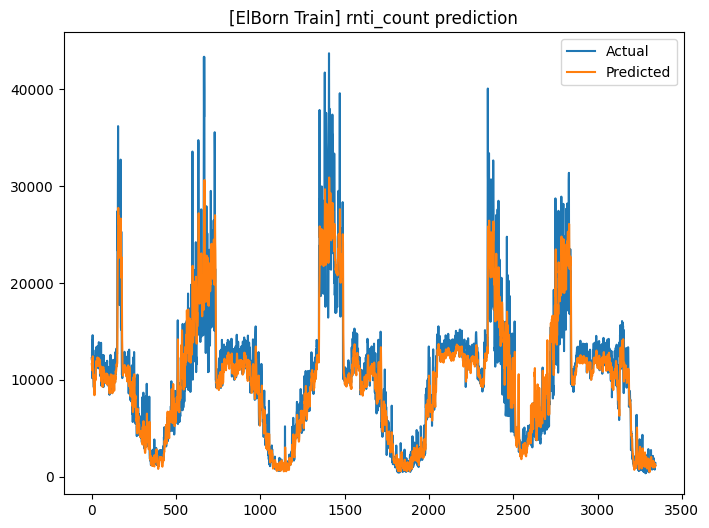

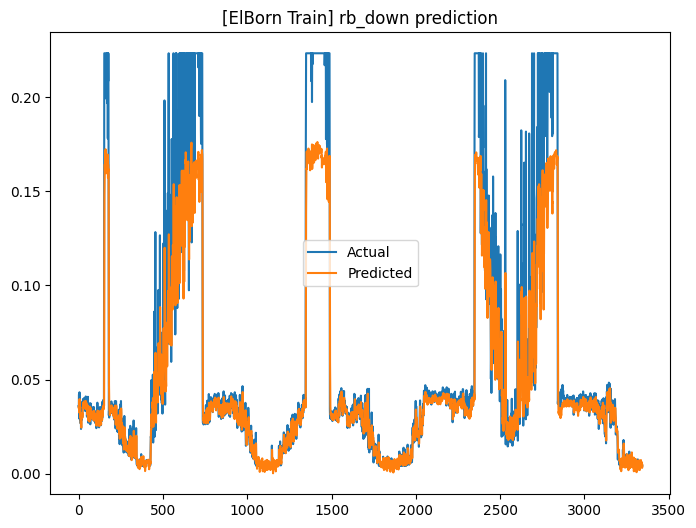

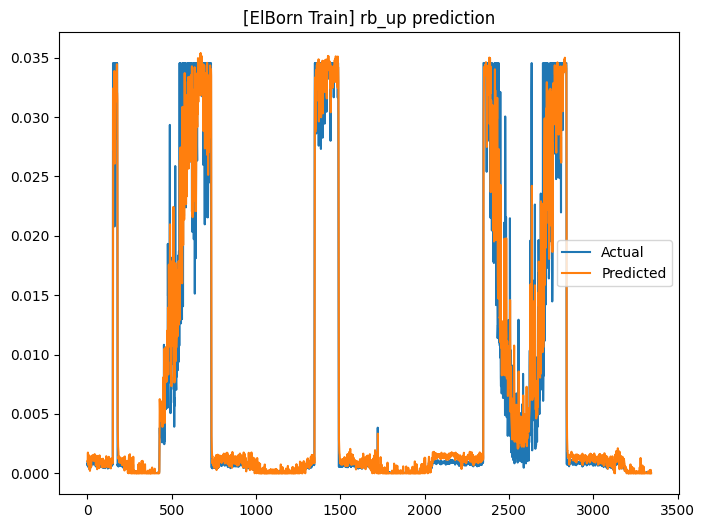

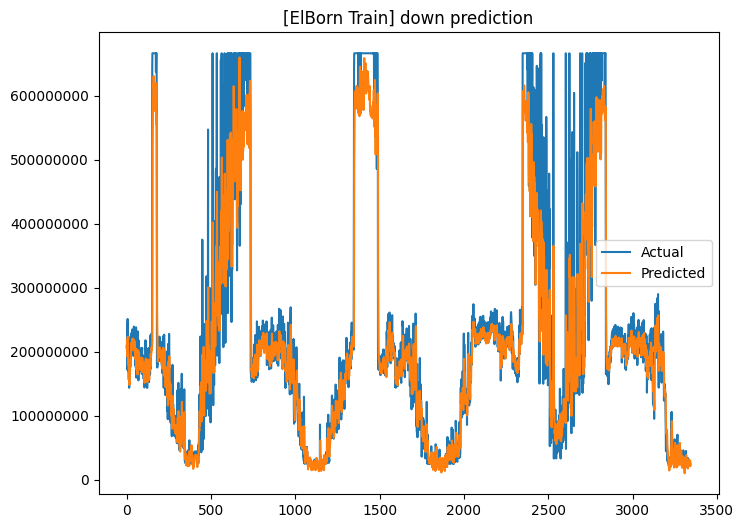

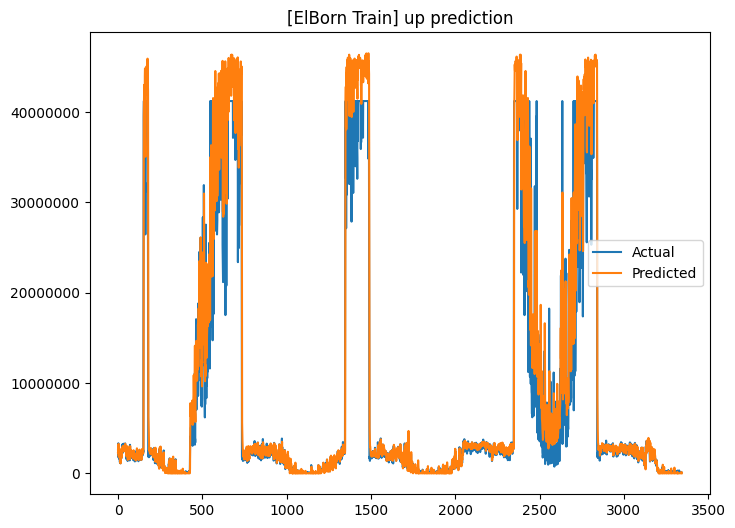

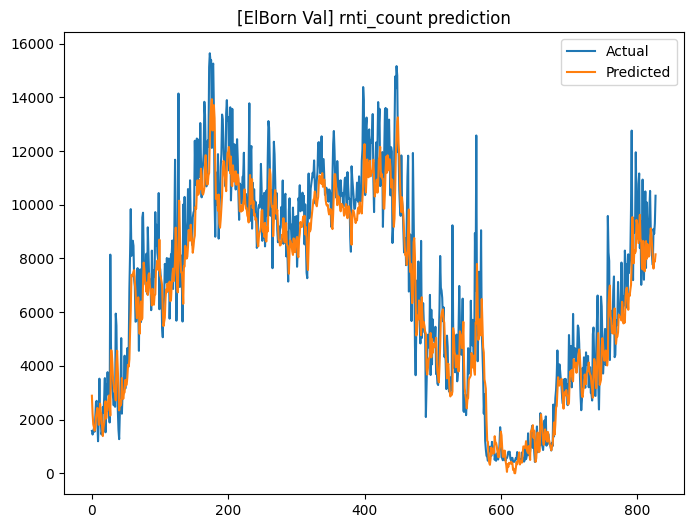

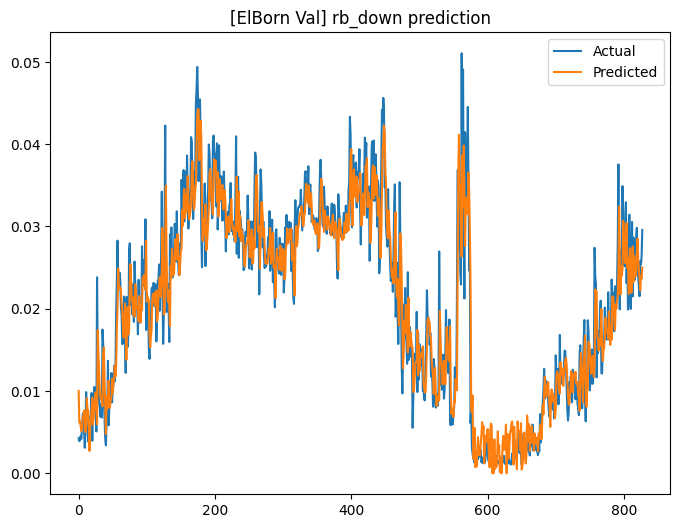

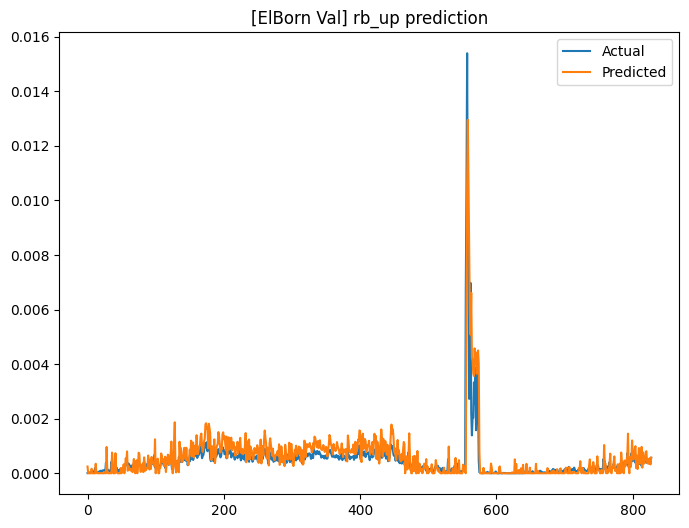

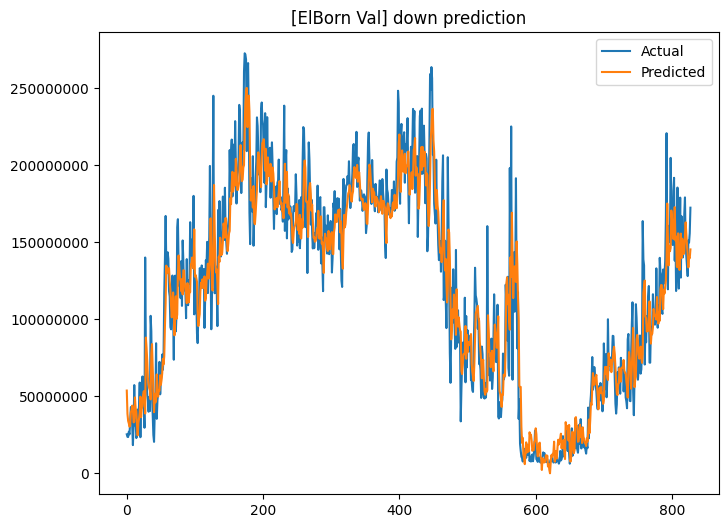

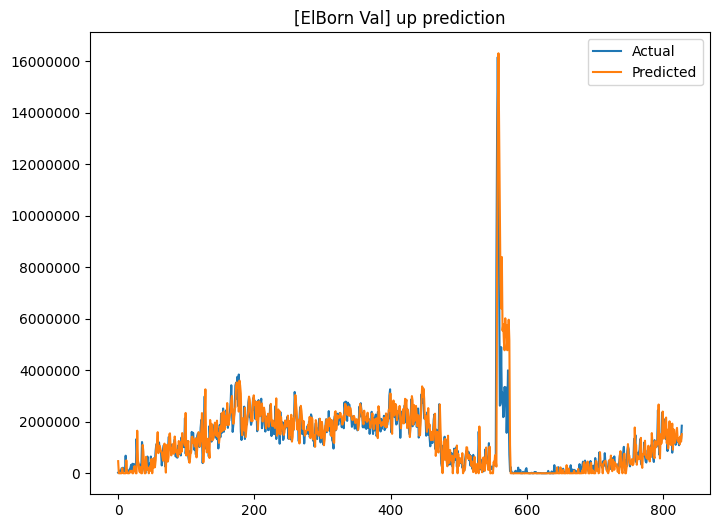

INFO logger 2022-10-26 13:52:50,146 | helpers.py:60 | Metrics for dimension: 0
	mse: 2085320.5, rmse: 1444.0638836284218, mae: 1081.6055908203125, r^2: 0.7606193151605711, nrmse: 0.28708962219838385
INFO logger 2022-10-26 13:52:50,147 | helpers.py:60 | Metrics for dimension: 1
	mse: 0.00011330821143928915, rmse: 0.01064463298753363, mae: 0.007305738516151905, r^2: -1.4084765908230046, nrmse: 0.6870642734153357
INFO logger 2022-10-26 13:52:50,148 | helpers.py:60 | Metrics for dimension: 2
	mse: 5.346036232367624e-06, rmse: 0.0023121496993853195, mae: 0.0011555009987205267, r^2: 0.886633473579308, nrmse: 0.4912688774384432
INFO logger 2022-10-26 13:52:50,149 | helpers.py:60 | Metrics for dimension: 3
	mse: 785734202032128.0, rmse: 28030950.78715897, mae: 21328556.0, r^2: 0.555409144549144, nrmse: 0.39238147271910173
INFO logger 2022-10-26 13:52:50,150 | helpers.py:60 | Metrics for dimension: 4
	mse: 15642626359296.0, rmse: 3955076.0244647637, mae: 2051897.125, r^2: 0.857833519771423, nrm


Final Prediction on LesCorts (Inference Stage)
[Train]: mse: 160275814678528.0, rmse: 12660008.478612011, mae 4676317.0, r2: 0.3304037724474883, nrmse: 0.4558784634031712
[Val]: mse: 75001965314048.0, rmse: 8660367.50456053, mae 2988940.75, r2: 0.5691836920100924, nrmse: 0.3271841852455295




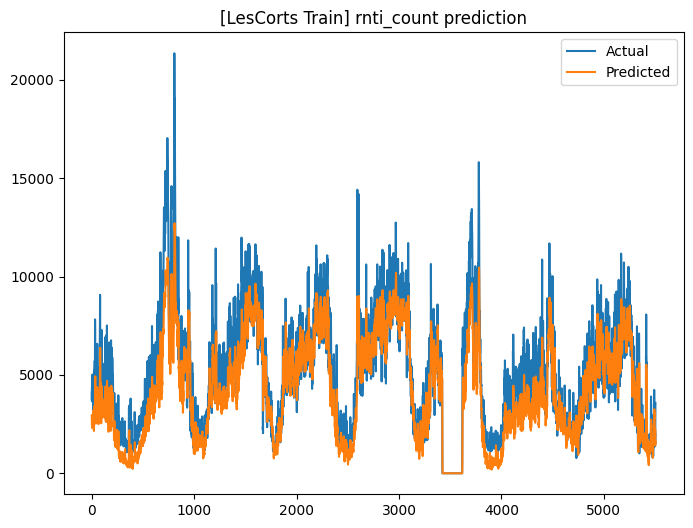

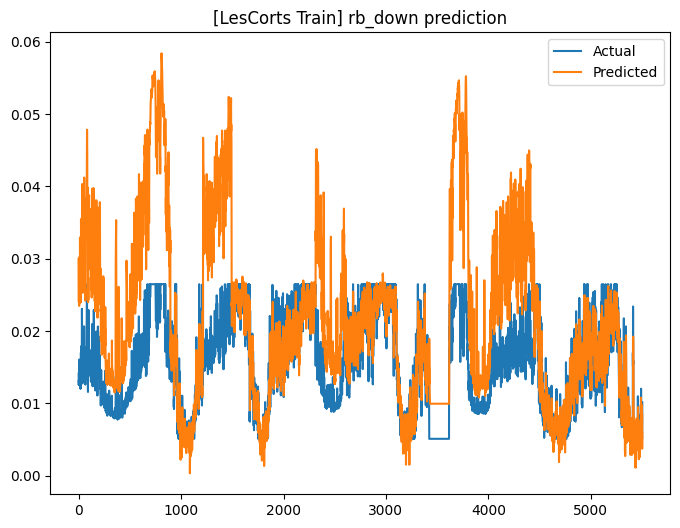

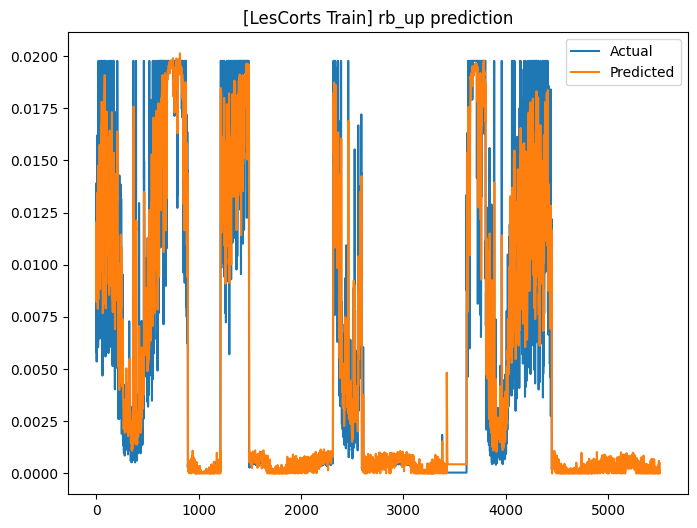

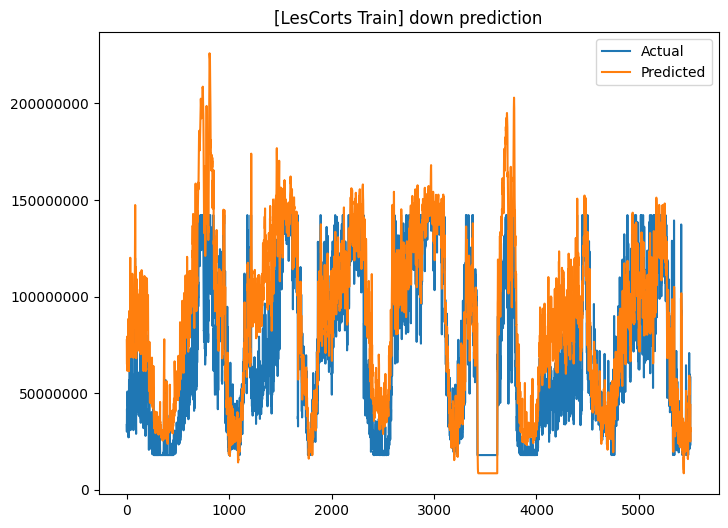

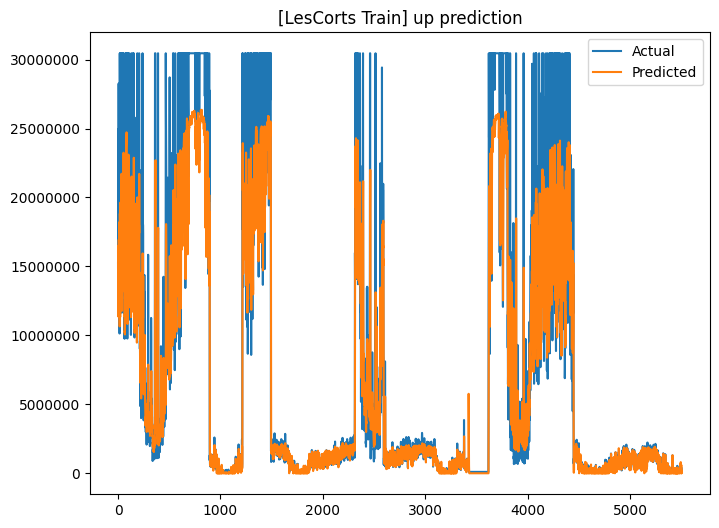

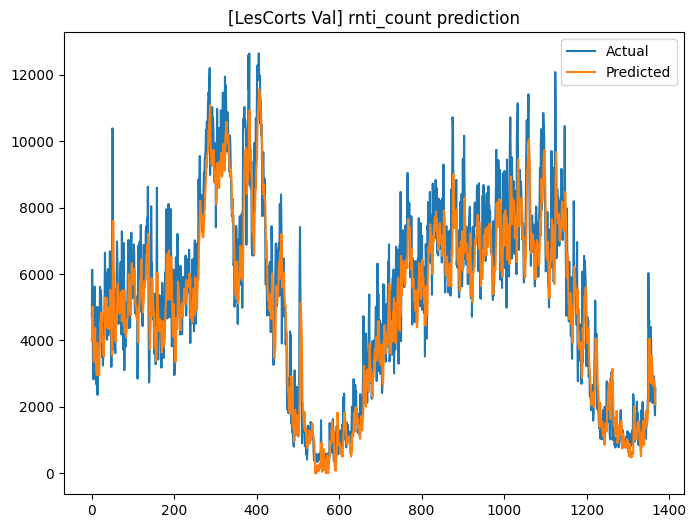

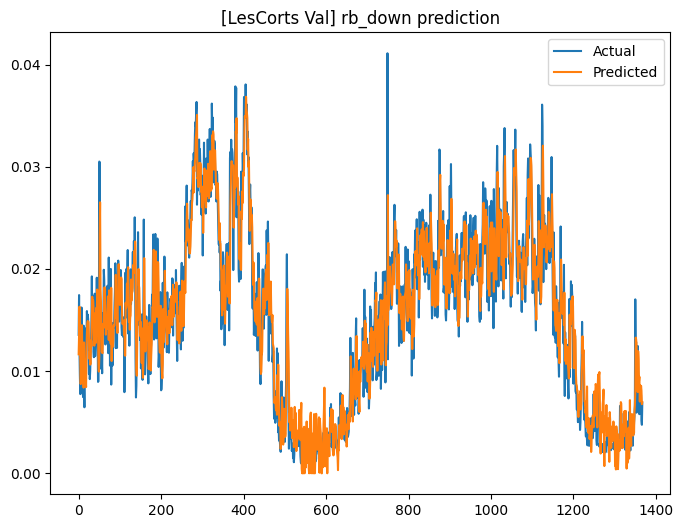

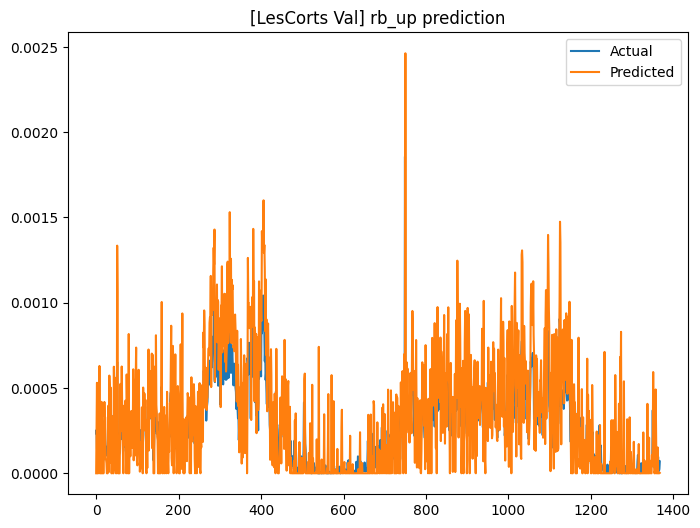

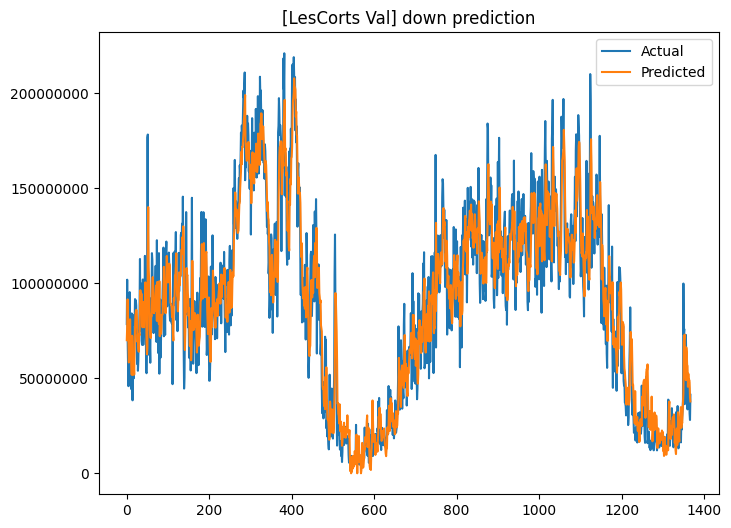

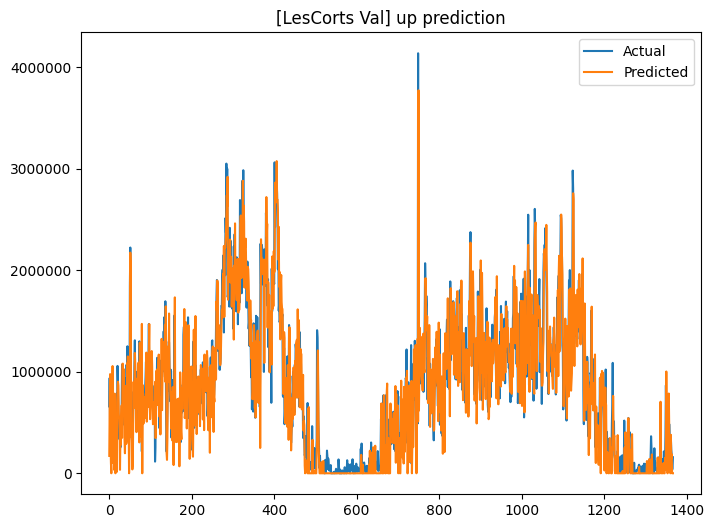

INFO logger 2022-10-26 13:52:51,112 | helpers.py:60 | Metrics for dimension: 0
	mse: 3597453.25, rmse: 1896.6953498124046, mae: 1366.1690673828125, r^2: 0.3936646042646488, nrmse: 0.34734919299171335
INFO logger 2022-10-26 13:52:51,113 | helpers.py:60 | Metrics for dimension: 1
	mse: 0.00029380785417743027, rmse: 0.017140824197728367, mae: 0.008913053199648857, r^2: 0.8236828373847697, nrmse: 0.4952962898925896
INFO logger 2022-10-26 13:52:51,114 | helpers.py:60 | Metrics for dimension: 2
	mse: 2.4518207283108495e-05, rmse: 0.00495158634006401, mae: 0.0020048138685524464, r^2: 0.8767623793782484, nrmse: 0.6599560447405308
INFO logger 2022-10-26 13:52:51,115 | helpers.py:60 | Metrics for dimension: 3
	mse: 2153953747795968.0, rmse: 46410707.25377893, mae: 29002300.0, r^2: 0.7774107727988033, nrmse: 0.3619399402364374
INFO logger 2022-10-26 13:52:51,116 | helpers.py:60 | Metrics for dimension: 4
	mse: 39341493583872.0, rmse: 6272279.775637563, mae: 2539412.5, r^2: 0.8755438848157076, nrm


Final Prediction on PobleSec (Inference Stage)
[Train]: mse: 438658129723392.0, rmse: 20944166.961791344, mae 6308625.0, r2: 0.7494128957284354, nrmse: 0.4987065593720058
[Val]: mse: 858020313563136.0, rmse: 29291983.776506774, mae 7968437.0, r2: 0.5186668165709547, nrmse: 1.1490803329715797




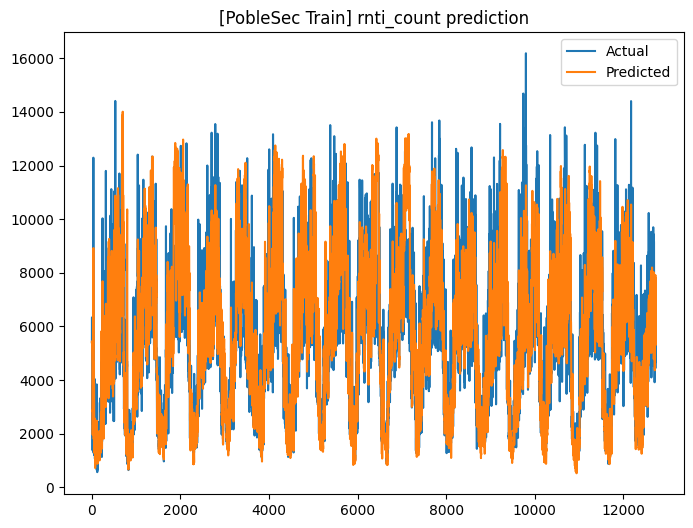

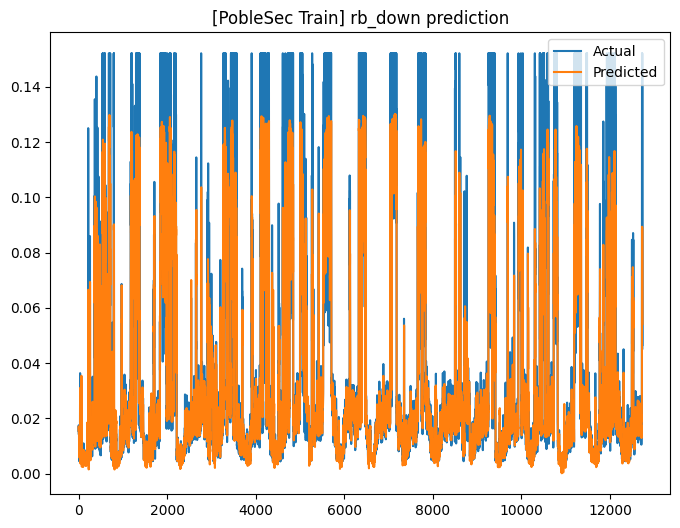

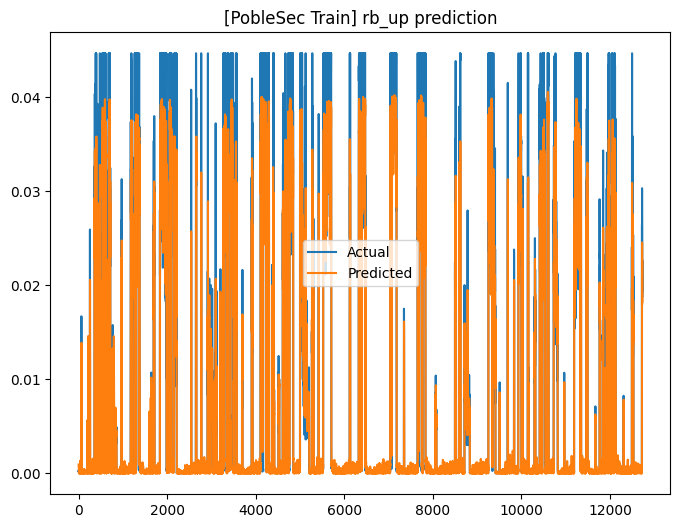

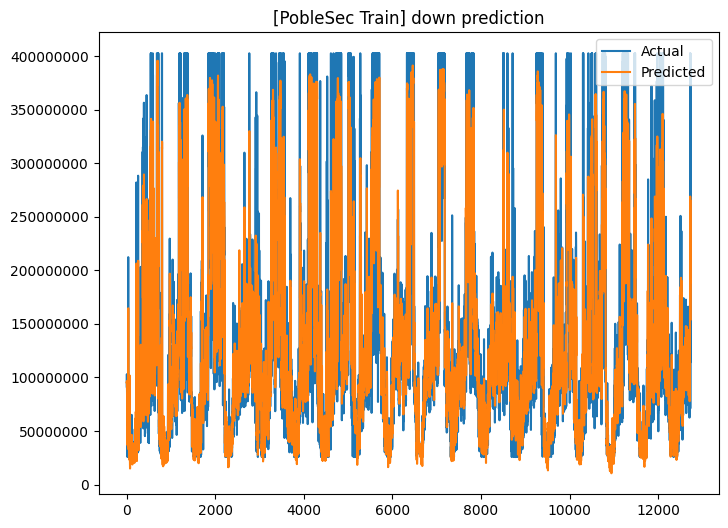

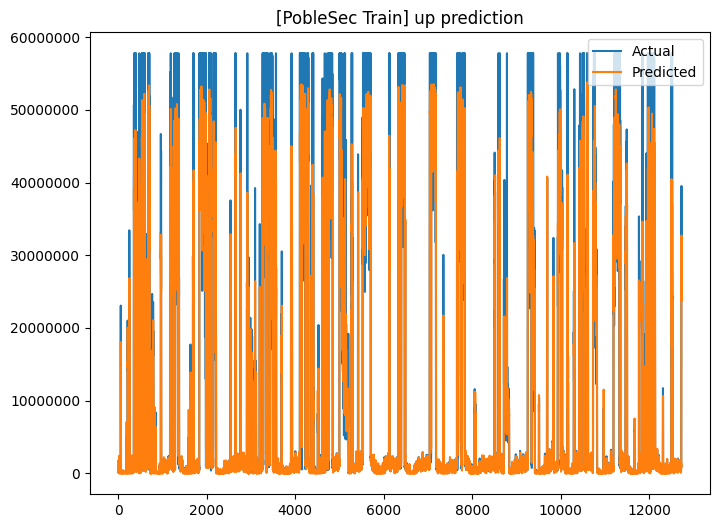

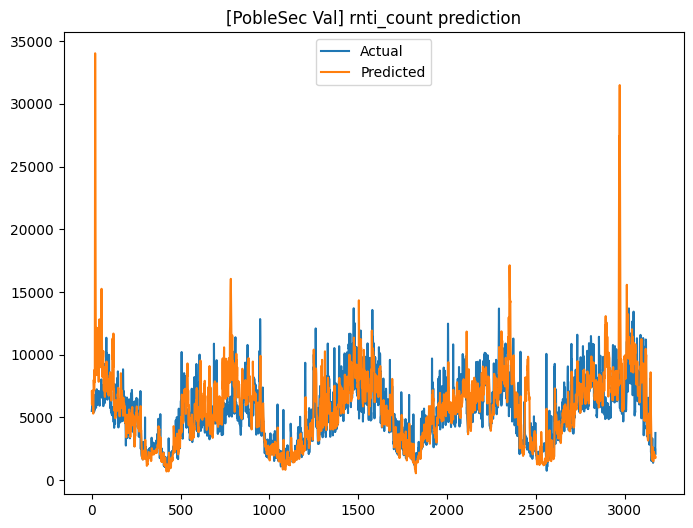

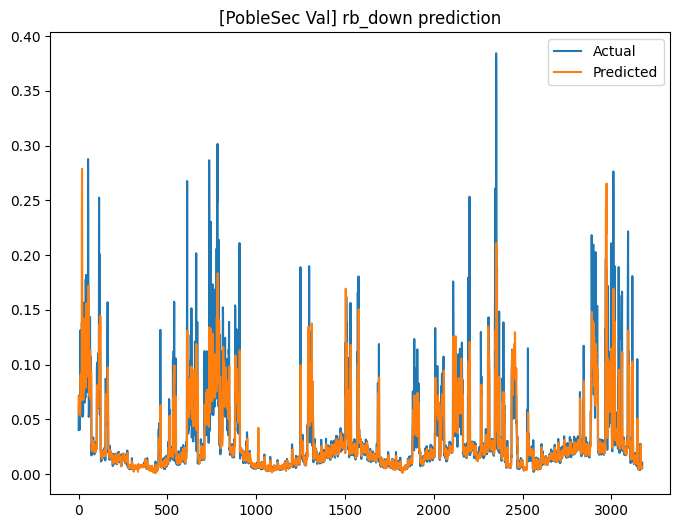

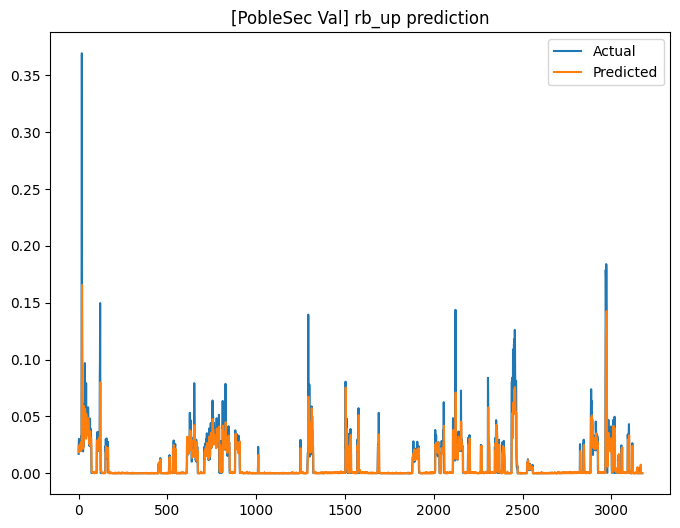

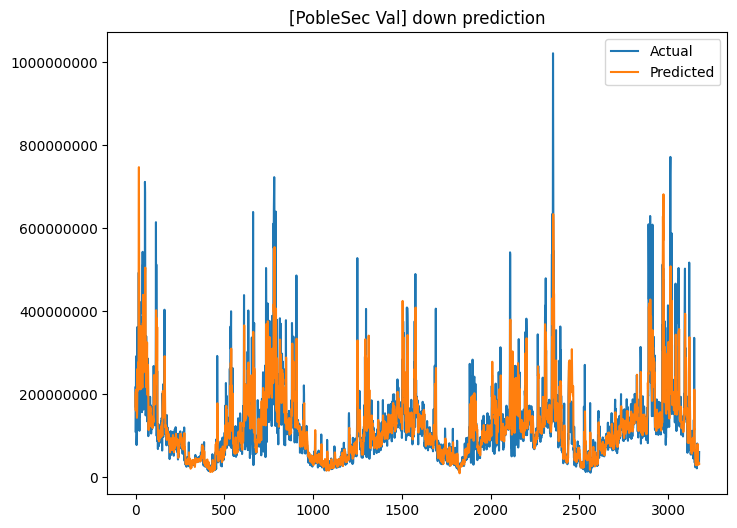

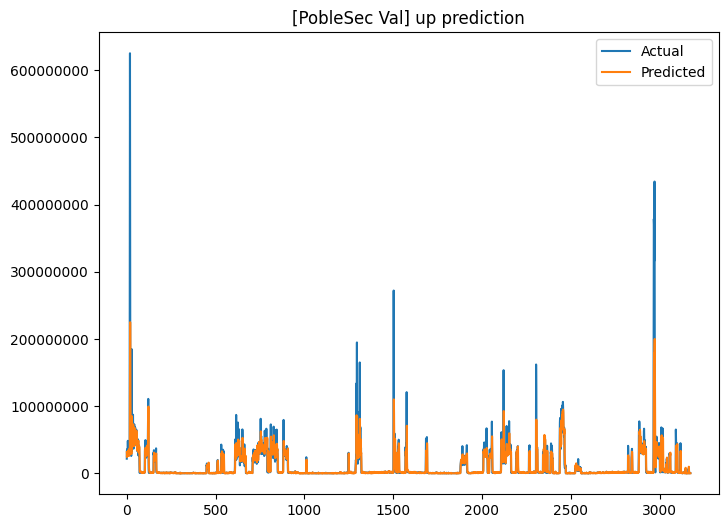

INFO logger 2022-10-26 13:52:52,828 | helpers.py:60 | Metrics for dimension: 0
	mse: 5566091.5, rmse: 2359.2565566296516, mae: 1624.669921875, r^2: 0.6278135042857729, nrmse: 0.2866762555340151
INFO logger 2022-10-26 13:52:52,828 | helpers.py:60 | Metrics for dimension: 1
	mse: 0.0012122179614380002, rmse: 0.03481692061969295, mae: 0.0132428128272295, r^2: 0.6447927748712596, nrmse: 0.7448648181518074
INFO logger 2022-10-26 13:52:52,829 | helpers.py:60 | Metrics for dimension: 2
	mse: 2.9400185667327605e-05, rmse: 0.0054221938057697275, mae: 0.0017969167092815042, r^2: 0.692661809616983, nrmse: 1.1516170489865782
INFO logger 2022-10-26 13:52:52,830 | helpers.py:60 | Metrics for dimension: 3
	mse: 7040009743892480.0, rmse: 83904765.91882299, mae: 41194364.0, r^2: 0.6816701733363246, nrmse: 0.4509841986629556
INFO logger 2022-10-26 13:52:52,831 | helpers.py:60 | Metrics for dimension: 4
	mse: 67017369452544.0, rmse: 8186413.711298984, mae: 2713223.5, r^2: 0.5829887272829142, nrmse: 1.274

Final Prediction in ElBorn
[Test]: mse: 1421404662661120.0, rmse: 37701520.694278635, mae 8781842.0, r2: 0.6459853978786508, nrmse: 0.8628567128160787




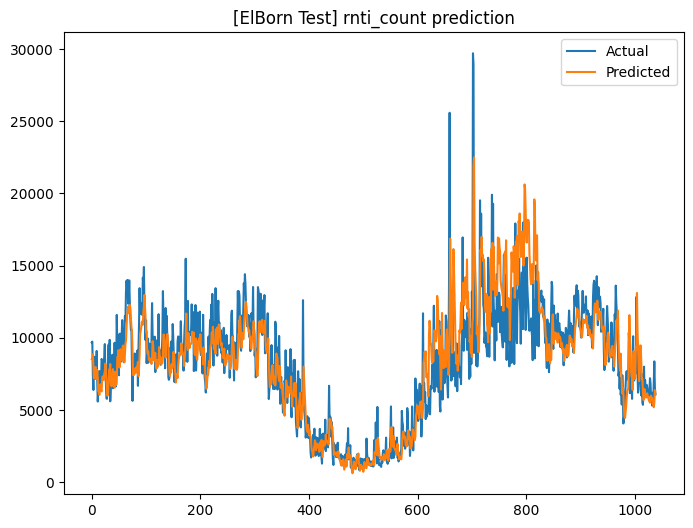

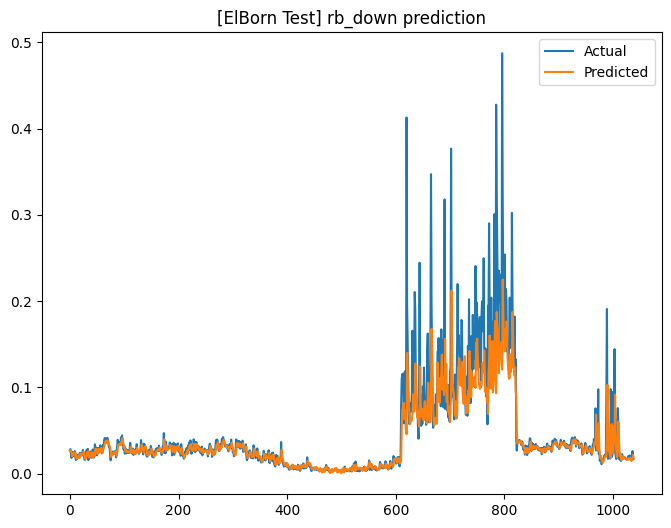

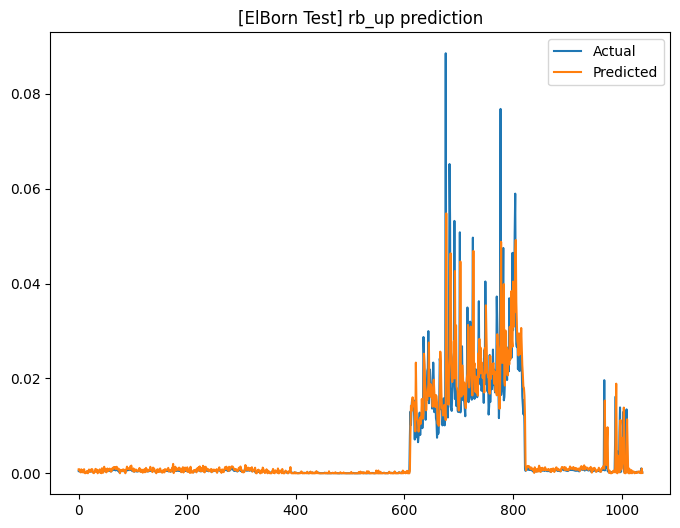

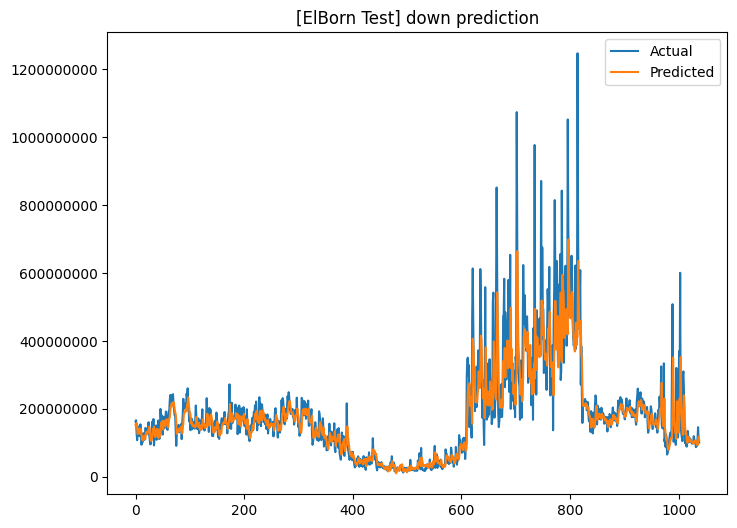

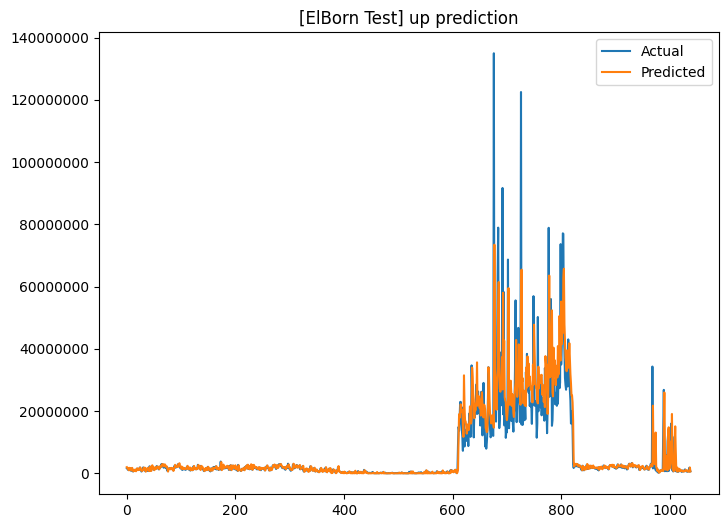

INFO logger 2022-10-26 13:52:53,803 | helpers.py:60 | Metrics for dimension: 0
	mse: 1475383.25, rmse: 1214.6535514293778, mae: 934.4512329101562, r^2: 0.7985638798407826, nrmse: 0.18847571425542486
INFO logger 2022-10-26 13:52:53,804 | helpers.py:60 | Metrics for dimension: 1
	mse: 1.2620949746633414e-05, rmse: 0.003552597605504093, mae: 0.0027468211483210325, r^2: 0.8086074632169896, nrmse: 0.19117052230590997
INFO logger 2022-10-26 13:52:53,805 | helpers.py:60 | Metrics for dimension: 2
	mse: 6.414749265104547e-08, rmse: 0.0002532735530035567, mae: 0.00019086050451733172, r^2: -0.6868710762489256, nrmse: 0.7642123416047935
INFO logger 2022-10-26 13:52:53,806 | helpers.py:60 | Metrics for dimension: 3
	mse: 412892654469120.0, rmse: 20319760.197136186, mae: 15716163.0, r^2: 0.8148610467895103, nrmse: 0.1864613667046854
INFO logger 2022-10-26 13:52:53,806 | helpers.py:60 | Metrics for dimension: 4
	mse: 158407737344.0, rmse: 398004.69512808515, mae: 303723.90625, r^2: 0.599911092865361

Final Prediction in LesCorts
[Test]: mse: 82610264997888.0, rmse: 9089018.92383815, mae 3204166.5, r2: 0.4670144812927436, nrmse: 0.2822581462148616




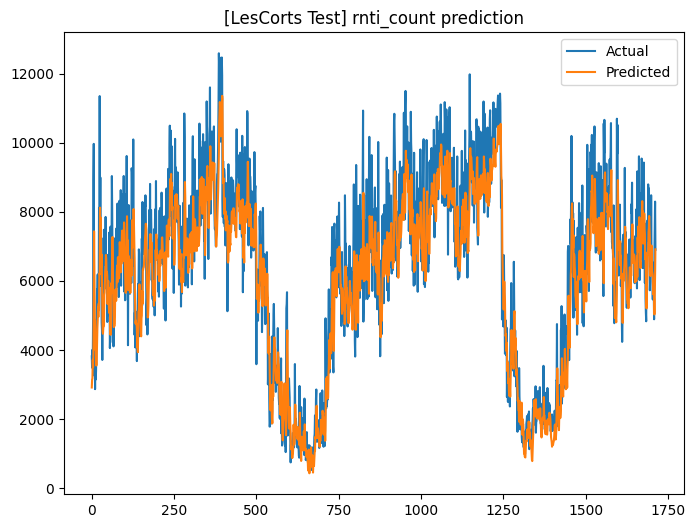

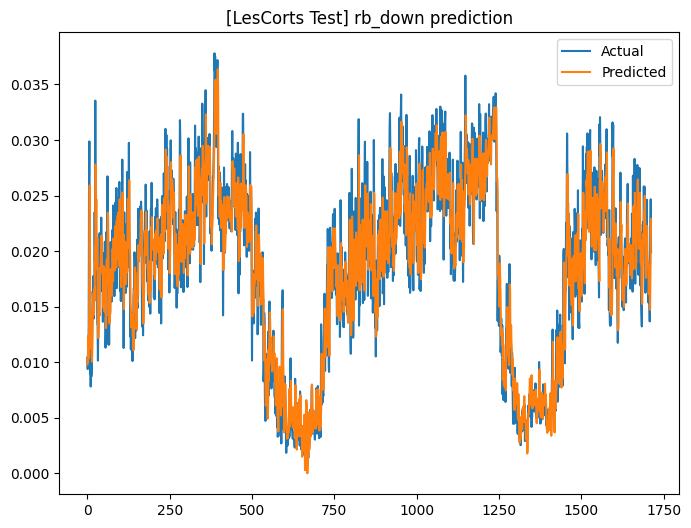

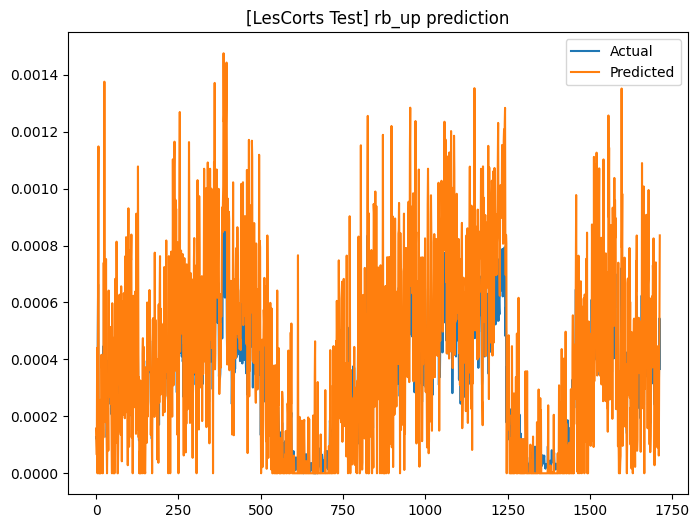

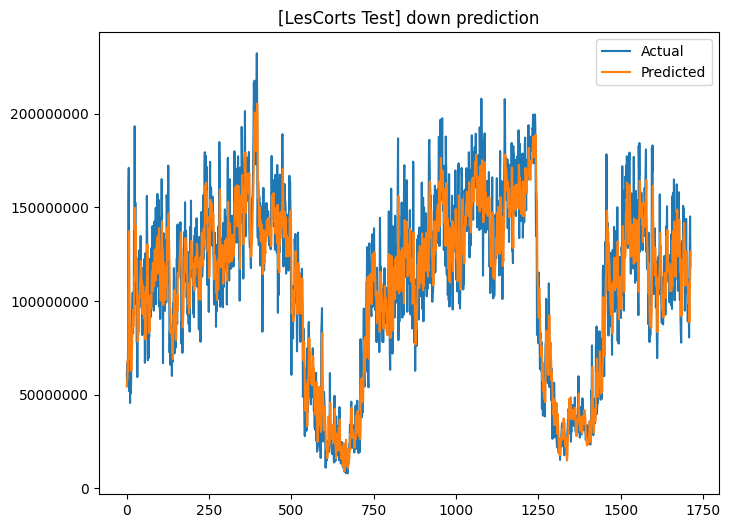

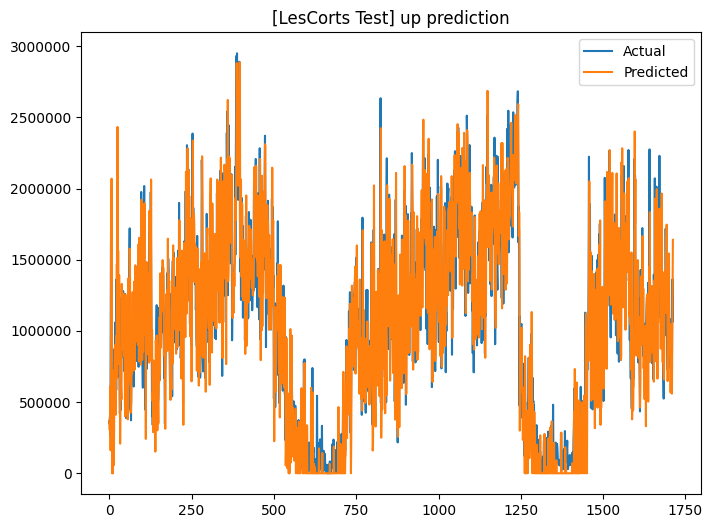

INFO logger 2022-10-26 13:52:55,433 | helpers.py:60 | Metrics for dimension: 0
	mse: 7922470.5, rmse: 2814.68834864537, mae: 1850.1964111328125, r^2: -0.1374799689424182, nrmse: 0.47422936254764253
INFO logger 2022-10-26 13:52:55,434 | helpers.py:60 | Metrics for dimension: 1
	mse: 0.0014307446544989944, rmse: 0.03782518545227497, mae: 0.01610798016190529, r^2: 0.6396940013159963, nrmse: 0.778851221755598
INFO logger 2022-10-26 13:52:55,435 | helpers.py:60 | Metrics for dimension: 2
	mse: 0.00012174202856840566, rmse: 0.01103367701939864, mae: 0.0038984802085906267, r^2: 0.6828170630622951, nrmse: 1.052382621316392
INFO logger 2022-10-26 13:52:55,436 | helpers.py:60 | Metrics for dimension: 3
	mse: 6621401830129664.0, rmse: 81371996.59667732, mae: 44096456.0, r^2: 0.6520838811748715, nrmse: 0.5063421112868803
INFO logger 2022-10-26 13:52:55,437 | helpers.py:60 | Metrics for dimension: 4
	mse: 250462561370112.0, rmse: 15826009.015860947, mae: 5083572.5, r^2: 0.6132527633655134, nrmse: 1

Final Prediction in PobleSec
[Test]: mse: 1374369670496256.0, rmse: 37072492.09988797, mae 9836386.0, r2: 0.4900735479952516, nrmse: 0.8345467447587882




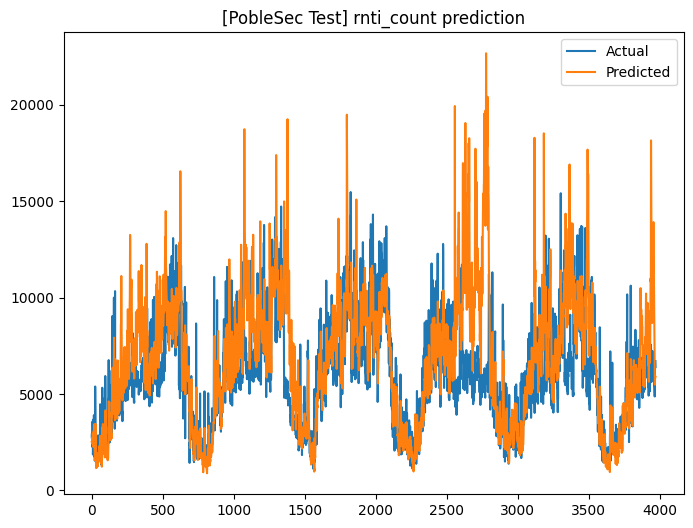

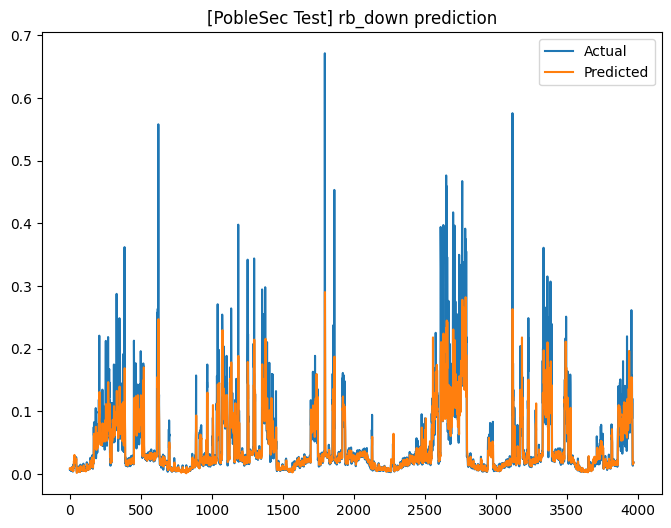

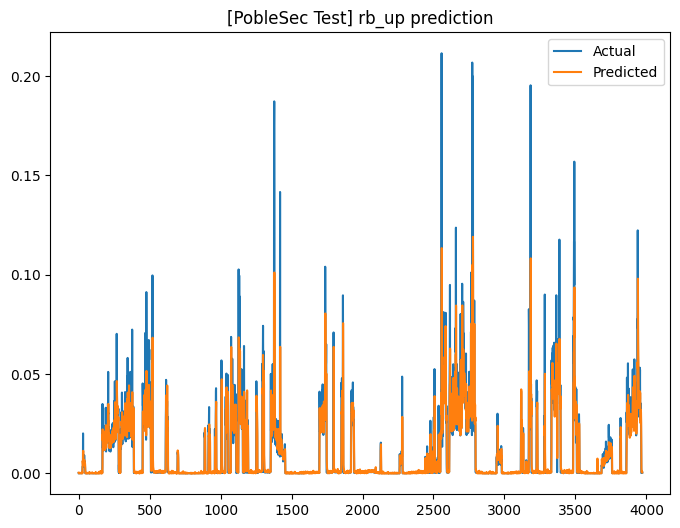

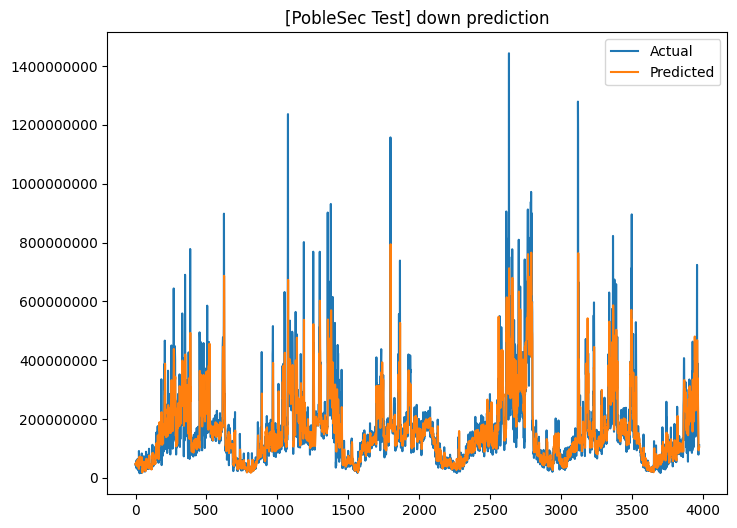

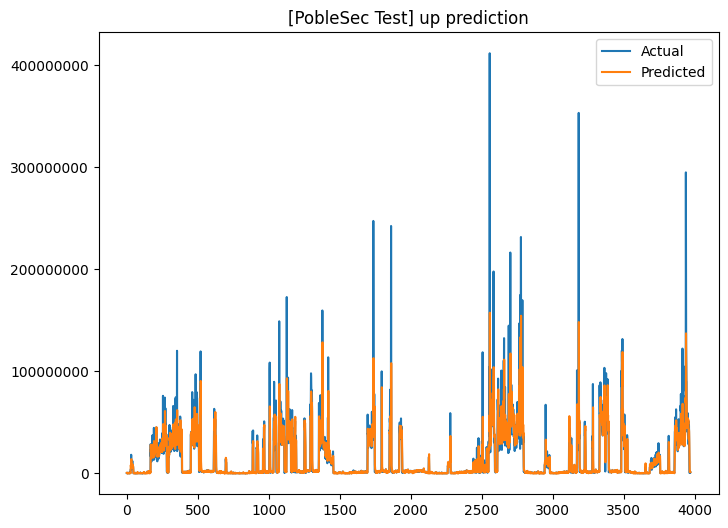

In [26]:
global_model, history, x_scaler, y_scaler = make_pipeline()

In [27]:
val_nrmses

{'fednova2': {'ElBorn': 0.4097697225843846,
  'LesCorts': 0.3271841852455295,
  'PobleSec': 1.1490803329715797}}

In [28]:
test_nrmses

{'fednova2': {'ElBorn': 0.8628567128160787,
  'LesCorts': 0.2822581462148616,
  'PobleSec': 0.8345467447587882}}

In [29]:
def plot_hist(x, title=None, is_metric=False, target=None):
    assert target in ["RMSE", "MAE", "NRMSE", None]
    if isinstance(x, dict) and not is_metric:
        for bs in x:
            plt.plot(x[bs].values(), label=str(bs))
        plt.legend()
    
    elif is_metric:
        for bs in x:
            bs_hist = list(x[bs].values())
            hist_list = []
            for epoch in bs_hist:
                for k in epoch:
                    if k == target:
                        hist_list.append(epoch[k])
            plt.plot(hist_list, label=str(bs))
        plt.legend()
            
    else:
        plt.plot(x)
    if title is not None:
        plt.title(title)
    
    plt.show()
    plt.close()

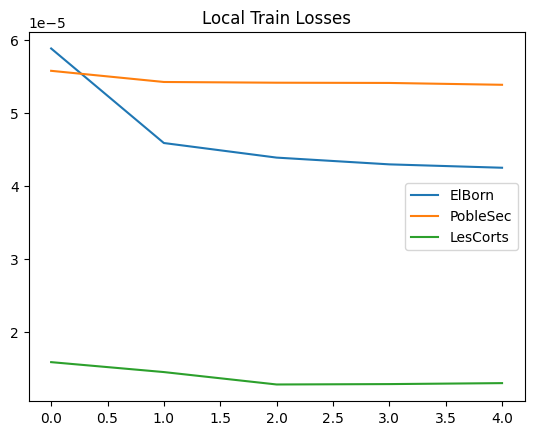

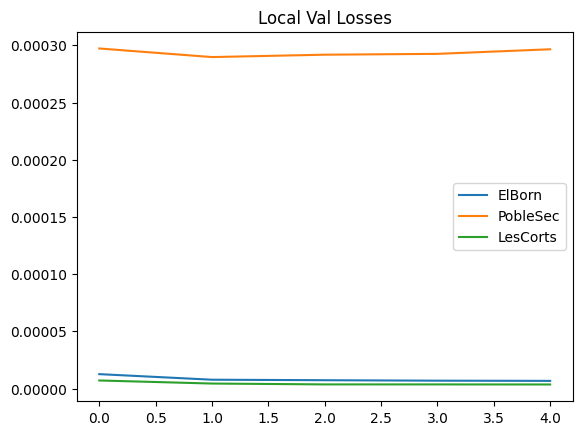

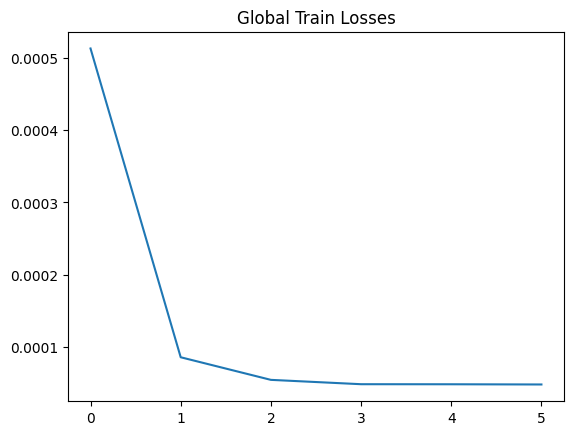

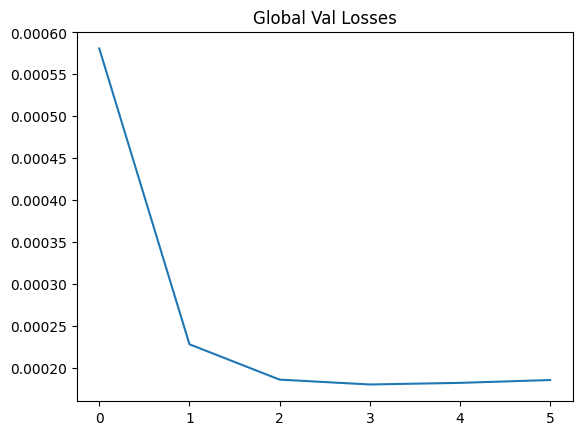

In [30]:
plot_hist(history.local_train_losses, title="Local Train Losses")
plot_hist(history.local_test_losses, title="Local Val Losses")
plot_hist(history.global_train_losses, title="Global Train Losses")
plot_hist(history.global_test_losses, title="Global Val Losses")

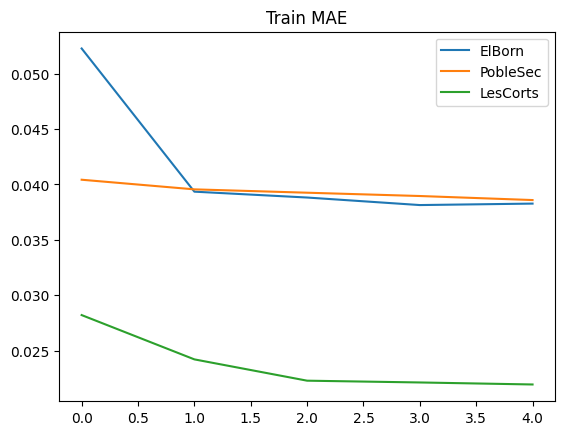

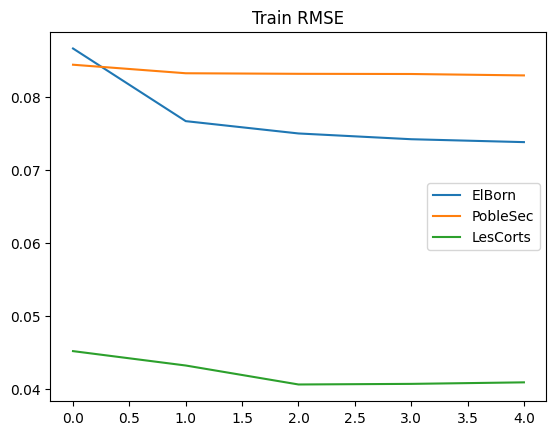

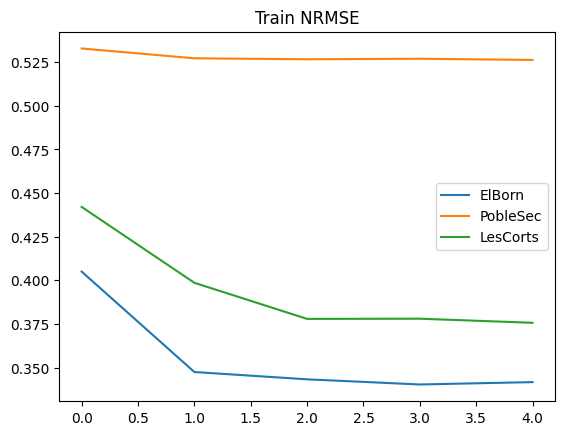

In [31]:
plot_hist(history.local_train_metrics, title="Train MAE", is_metric=True, target="MAE")
plot_hist(history.local_train_metrics, title="Train RMSE", is_metric=True, target="RMSE")
plot_hist(history.local_train_metrics, title="Train NRMSE", is_metric=True, target="NRMSE")

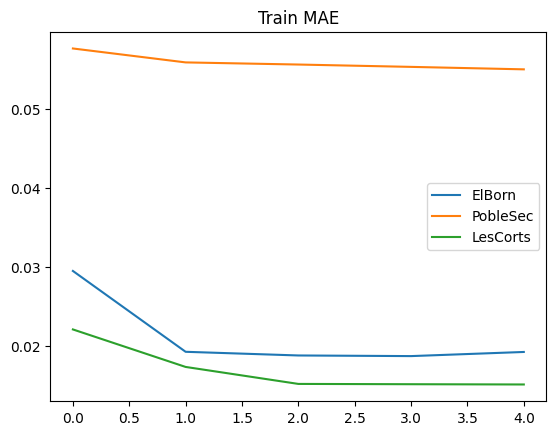

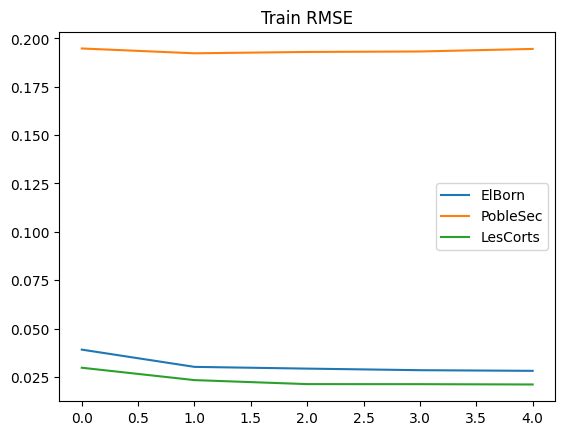

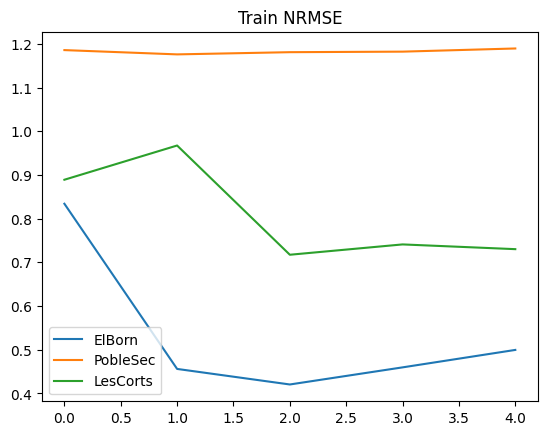

In [32]:
plot_hist(history.local_test_metrics, title="Train MAE" ,is_metric=True, target="MAE")
plot_hist(history.local_test_metrics, title="Train RMSE", is_metric=True, target="RMSE")
plot_hist(history.local_test_metrics, title="Train NRMSE", is_metric=True, target="NRMSE")

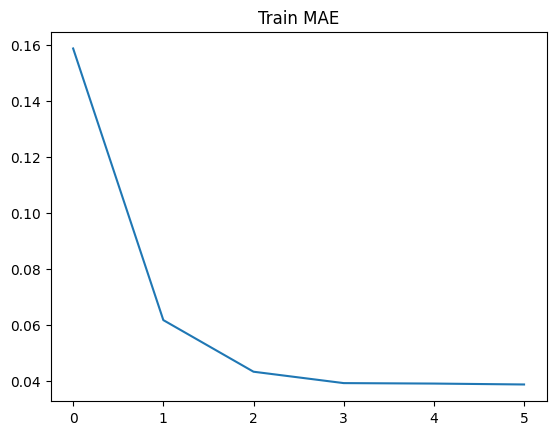

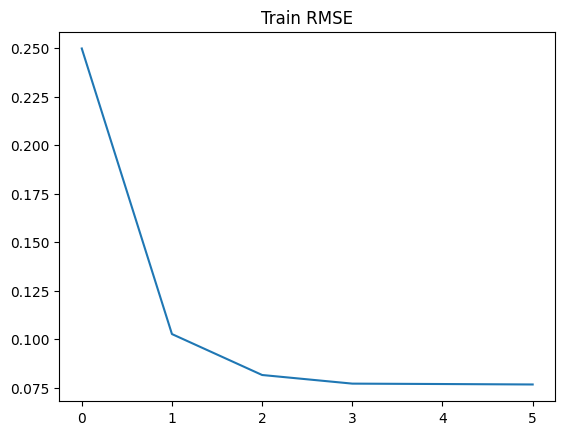

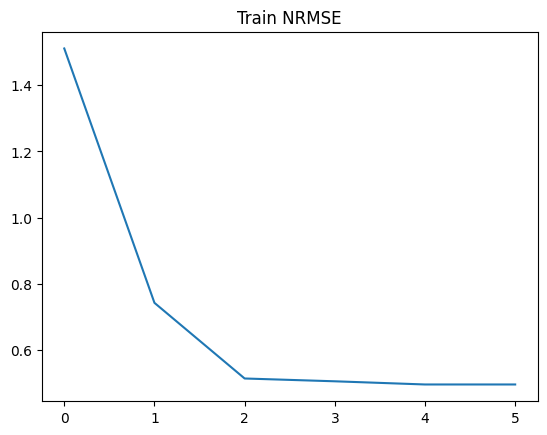

In [33]:
plot_hist(history.global_train_metrics["MAE"], title="Train MAE", )
plot_hist(history.global_train_metrics["RMSE"], title="Train RMSE", )
plot_hist(history.global_train_metrics["NRMSE"], title="Train NRMSE", )

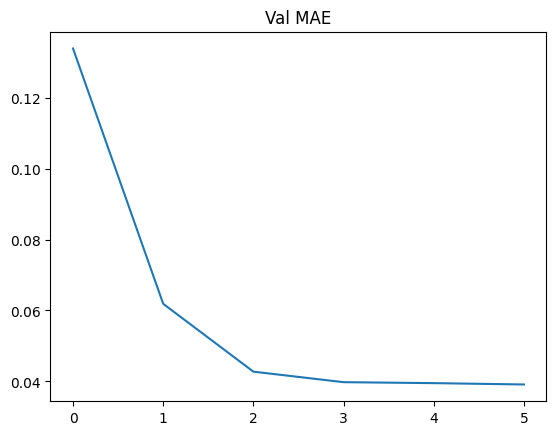

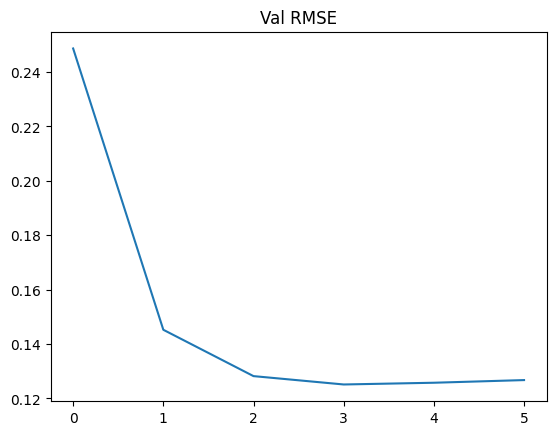

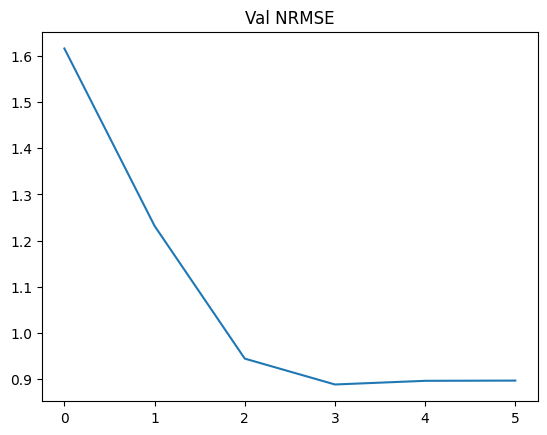

In [34]:
plot_hist(history.global_test_metrics["MAE"], title="Val MAE")
plot_hist(history.global_test_metrics["RMSE"], title="Val RMSE")
plot_hist(history.global_test_metrics["NRMSE"], title="Val NRMSE")

In [35]:
global_model

LSTM(
  (lstm): LSTM(11, 128, batch_first=True)
  (MLP_layers): Sequential(
    (0): Linear(in_features=128, out_features=5, bias=True)
  )
)

In [36]:
import h5py

In [37]:
class ModelSerializer:
    def __init__(self, 
                 model_state, 
                 save_path: str):
        self.model_state = model_state
        self.save_path = save_path

    def save(self):
        np_weights = self.state_to_numpy(self.model_state)
        with h5py.File(self.save_path, "w") as f:
            group = f.create_group("model_weights", track_order=True)
            for k, v in np_weights.items():
                group[k] = v
            

    @staticmethod
    def state_to_numpy(model_state):
        assert type(model_state) in (dict, OrderedDict), \
            f"Model state must be of type dictionary. Received {type(model_state)}"
        k = next(iter(model_state))
        assert type(model_state[k]) in (torch.tensor, torch.Tensor, np.ndarray), \
            f"Model weights must be of type torch.tensor or numpy.ndarray. Received {type(model_state[k])}"
        if type(model_state[k]) == np.ndarray:
            return model_state
        np_ordered_dict = OrderedDict()
        for k, v in model_state.items():
            np_ordered_dict[k] = v.cpu().numpy().astype(np.float64)
        return np_ordered_dict

In [38]:
serializer = ModelSerializer(global_model.state_dict(), save_path="model_checkpoint/LSTM_FL_FedNova_weights_bs128_c1.h5")

In [39]:
serializer.save()

In [40]:
x_scaler, y_scaler

(MinMaxScaler(), MinMaxScaler())

In [41]:
def get_minmax_attrs(scaler):
    scaler_attrs = dict()
    scaler_attrs["min_"] = scaler.min_
    scaler_attrs["scale_"] = scaler.scale_
    scaler_attrs["data_min_"] = scaler.data_min_
    scaler_attrs["data_max_"] = scaler.data_max_
    scaler_attrs["data_range_"] = scaler.data_range_
    scaler_attrs["n_features_in_"] = np.array([scaler.n_features_in_])
    scaler_attrs["n_samples_seen_"] = np.array([scaler.n_samples_seen_])
    scaler_attrs["feature_names_in_"] = scaler.feature_names_in_
    
    print(scaler_attrs)
    
    return scaler_attrs

In [42]:
class ScalerSerializer:
    def __init__(self, 
                 x_scaler_state,
                 y_scaler_state,
                 save_path: str):
        self.save_path = save_path
        self.x_scaler = x_scaler_state
        self.y_scaler = y_scaler_state

    def save(self):
        with h5py.File(self.save_path, "w") as f:
            group = f.create_group("x_scaler", track_order=True)
            for k, v in self.x_scaler.items():
                group[k] = v
            group=f.create_group("y_scaler", track_order=True)
            for k, v in self.y_scaler.items():
                group[k] = v
            

In [43]:
x_scaler_attrs = get_minmax_attrs(x_scaler)
print("\n\n")
y_scaler_attrs = get_minmax_attrs(y_scaler)

{'min_': array([-0.02778567, -0.0008259 ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.0189285 ,  0.        , -0.00037316,
        0.        ], dtype=float32), 'scale_': array([1.5418619e-09, 1.7316220e-08, 2.2870212e-05, 6.1176602e-02,
       9.9160559e-03, 3.2258064e-02, 4.1493778e-03, 4.5598941e+00,
       1.0000000e+00, 2.2389420e+01, 1.0000000e+00], dtype=float32), 'data_min_': array([1.8020858e+07, 4.7695199e+04, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 4.1510835e-03,
       0.0000000e+00, 1.6666667e-05, 0.0000000e+00], dtype=float32), 'data_max_': array([6.6658739e+08, 5.7797020e+07, 4.3725000e+04, 1.6346119e+01,
       1.0084655e+02, 3.1000000e+01, 2.4100000e+02, 2.2345443e-01,
       1.7914095e-07, 4.4680621e-02, 9.3972027e-08], dtype=float32), 'data_range_': array([6.4856653e+08, 5.7749324e+07, 4.3725000e+04, 1.6346119e+01,
       1.0084655e+02, 3.1000000e+01, 2.4100000e+02, 2.1930334e-01,
       1.7914095

In [44]:
serializer = ScalerSerializer(x_scaler_attrs, y_scaler_attrs, save_path="model_checkpoint/scalers.h5")
serializer.save()